# PCA and Clustering - Sentiment Clustering by Date

### Import Libraries

In [1]:
import pandas as pd
import numpy as np

from data.time_series_functions import vs_previous_high
from data.db_interaction import DatabaseInteraction

from textblob import TextBlob

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

import hdbscan

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from datetime import datetime, timedelta
from itertools import product, combinations
from collections import Counter
from math import ceil

import pickle

# Set random state variable
rs = 13

### Import Data

In [2]:
# Import Reddit and Google Trends data
DI = DatabaseInteraction()

posts_df = DI.query_to_df(DI.query_all_data('posts'))
comments_df = DI.query_to_df(DI.query_all_data('comments'))
gtrends_df = DI.query_to_df(DI.query_all_data('gtrends'))
glassnode_df = DI.query_to_df(DI.query_all_data('glassnode'))
volume_df = DI.query_to_df(DI.query_all_data('volume'))

In [3]:
# Import article data
with open('sentiment_pickles/pickle_articles_modeling.pickle', 'rb') as read_file:
    articles_df = pickle.load(read_file)

In [4]:
# Import activty data (Google, Reddit)
with open('sentiment_pickles/pickle_activity_data.pickle', 'rb') as read_file:
    activity_df = pickle.load(read_file)

In [5]:
# Import article data
with open('sentiment_pickles/pickle_topics_by_article.pickle', 'rb') as read_file:
    topics_by_article = pickle.load(read_file)

### Calculate All-Time High Columns for Certain Metrics

In [6]:
# Add price and volume ATH drawdown columns
volume_df = vs_previous_high(volume_df, 'date', 'closing_price')
volume_df = vs_previous_high(volume_df, 'date', 'volume')

In [7]:
# Add active_addresses ATH drawdown column
glassnode_df = vs_previous_high(glassnode_df, 'date', 'active_addresses')

### Calculate Reddit Polarity and Subjectivity (VADER)

In [8]:
# Filter out stickied comments
comments_df = comments_df[comments_df['stickied'] == False]

# Add polarity column and and a scaled column (multiplied by upvotes)
comments_df['polarity'] = comments_df.apply(lambda row: TextBlob(row['body']).sentiment.polarity, axis=1)
comments_df['polarity_scaled'] = comments_df['polarity'] * comments_df['upvotes']
comments_df['subjectivity'] = comments_df.apply(lambda row: TextBlob(row['body']).sentiment.subjectivity, axis=1)
comments_df['subjectivity_scaled'] = comments_df['subjectivity'] * comments_df['upvotes']

In [9]:
# Group by date and describe
grouped_comments_df = comments_df.groupby('date')[['polarity', 'polarity_scaled', 'subjectivity', 'subjectivity_scaled']].mean()
grouped_comments_df.describe()

polarity  polarity_scaled  subjectivity  subjectivity_scaled
count  1267.000000      1267.000000   1267.000000          1267.000000
mean      0.086272         0.538417      0.360163             2.262322
std       0.053543         0.475258      0.061942             1.565295
min      -0.090448        -0.884625      0.122346            -1.599039
25%       0.052859         0.222592      0.321484             1.278610
50%       0.084809         0.458128      0.362503             1.863436
75%       0.116833         0.764321      0.398471             2.720690
max       0.326905         3.555851      0.635275            12.083050

In [10]:
# Find standard deviation of sentiment metrics
grouped_comments_std = comments_df.groupby('date')[['polarity', 'polarity_scaled', 'subjectivity', 'subjectivity_scaled']].std()

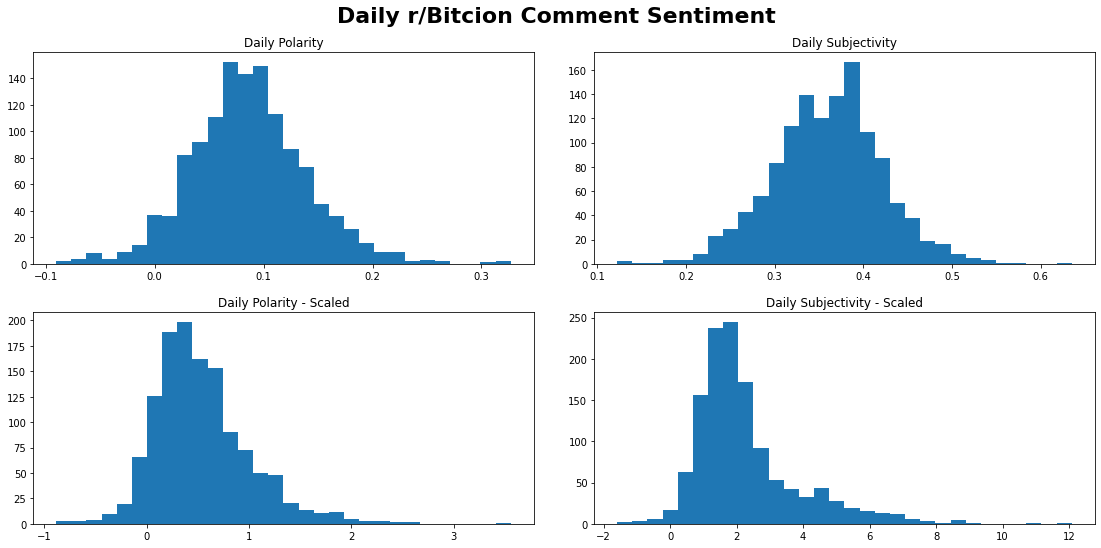

In [11]:
# Daily Polarity and Subjectivity, Histograms
fig, axes = plt.subplots(2, 2, figsize=[16, 8])
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
fig.suptitle('Daily r/Bitcion Comment Sentiment', fontsize=22, fontweight='bold')

cols = ['polarity', 'subjectivity', 'polarity_scaled', 'subjectivity_scaled']
titles = ['Daily Polarity', 'Daily Subjectivity', 'Daily Polarity - Scaled', 'Daily Subjectivity - Scaled']

for i in range(0,4):
    plt.subplot(2,2,i+1) # (number of rows, number of columns, number of plot)
    plt.hist(grouped_comments_df[cols[i]], bins=30)
    plt.title(titles[i])

plt.show();

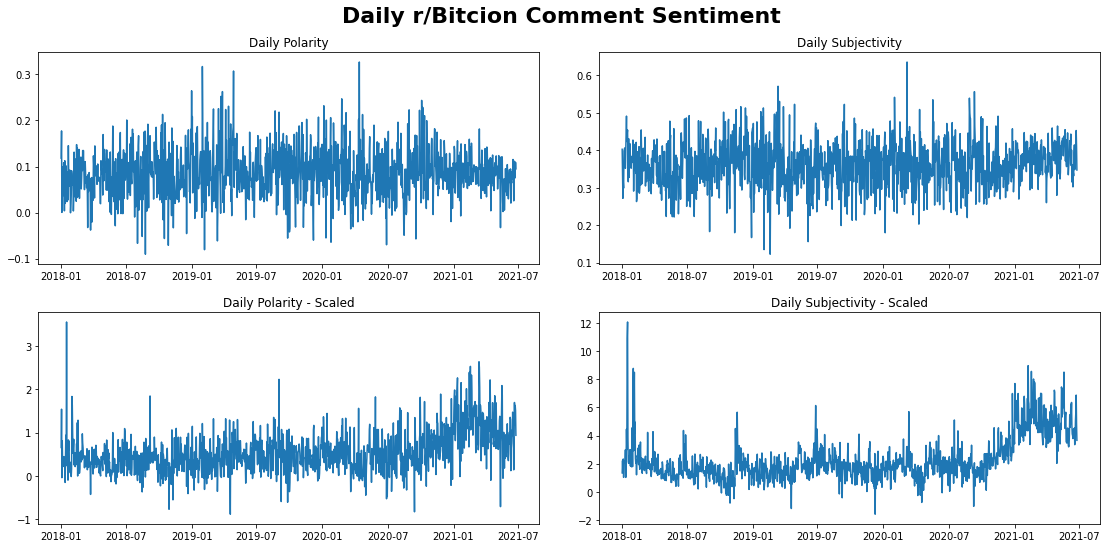

In [12]:
# Daily Polarity and Subjectivity, Line Plots
fig, axes = plt.subplots(2, 2, figsize=[16, 8])
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
fig.suptitle('Daily r/Bitcion Comment Sentiment', fontsize=22, fontweight='bold')

cols = ['polarity', 'subjectivity', 'polarity_scaled', 'subjectivity_scaled']
titles = ['Daily Polarity', 'Daily Subjectivity', 'Daily Polarity - Scaled', 'Daily Subjectivity - Scaled']

for i in range(0,4):
    plt.subplot(2,2,i+1) # (number of rows, number of columns, number of plot)
    plt.plot(grouped_comments_df[cols[i]])
    plt.title(titles[i])

plt.show();

### Calculate News Article Polarity and Subjectivity (VADER)

In [13]:
with open('sentiment_pickles/pickle_articles_modeling.pickle', 'rb') as read_file:
    articles_df = pickle.load(read_file)

In [14]:
articles_df['polarity'] = articles_df.apply(lambda row: TextBlob(row['body']).sentiment.polarity, axis=1)
articles_df['subjectivity'] = articles_df.apply(lambda row: TextBlob(row['body']).sentiment.subjectivity, axis=1)

In [15]:
articles_grouped = articles_df.groupby('date')[['polarity', 'subjectivity']].mean()

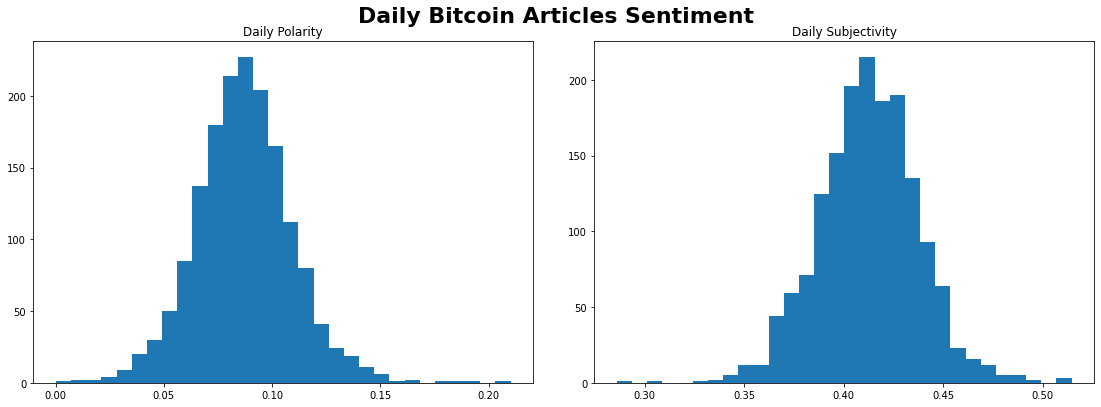

In [16]:
# Daily Polarity and Subjectivity, Line Plots
fig, axes = plt.subplots(1, 2, figsize=[16, 6])
fig.tight_layout(pad=3.0)
fig.suptitle('Daily Bitcoin Articles Sentiment', fontsize=22, fontweight='bold')
fig.subplots_adjust(top=0.9)

cols = ['polarity', 'subjectivity']
titles = ['Daily Polarity', 'Daily Subjectivity']

for i in range(0,2):
    plt.subplot(1,2,i+1) # (number of rows, number of columns, number of plot)
    plt.hist(articles_grouped[cols[i]], bins=30)
    plt.title(titles[i])
    

plt.show();

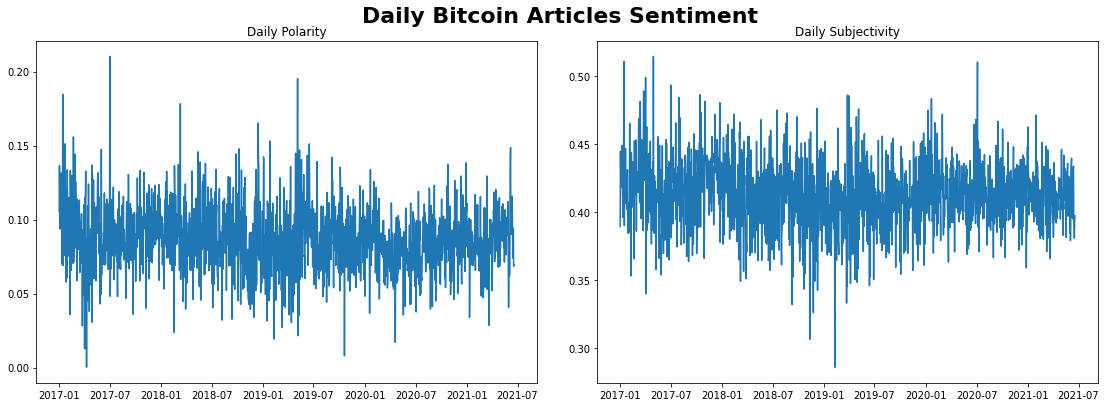

In [17]:
# Daily Polarity and Subjectivity, Line Plots
fig, axes = plt.subplots(1, 2, figsize=[16, 6])
fig.tight_layout(pad=3.0)
fig.suptitle('Daily Bitcoin Articles Sentiment', fontsize=22, fontweight='bold')
fig.subplots_adjust(top=0.9)

cols = ['polarity', 'subjectivity']
titles = ['Daily Polarity', 'Daily Subjectivity']

for i in range(0,2):
    plt.subplot(1, 2, i+1) # (number of rows, number of columns, number of plot)
    plt.plot(articles_grouped[cols[i]])
    plt.title(titles[i])
    

plt.show();

### Combine All DataFrames

In [18]:
# Convert timestamp columns to date columns
glassnode_df['date'] = glassnode_df['date'].apply(lambda x: x.date())
gtrends_df['date'] = gtrends_df['date'].apply(lambda x: x.date())

# Prepare dataframes for consolidation
glassnode_df = glassnode_df[['date', 'nupl', 'active_addresses', 'active_addresses_vs_ath', 'net_transfer_volume']]
volume_df = volume_df[['date', 'volume', 'volume_vs_ath', 'closing_price', 'closing_price_vs_ath']]

gtrends_df.rename(columns={'scaled_interest' : 'google_activity'}, inplace=True)
gtrends_df = gtrends_df[['date', 'google_activity']]

articles_grouped.reset_index(inplace=True)
articles_grouped.rename(columns={'polarity' : 'article_polarity', 'subjectivity' : 'article_subjectivity'},
                        inplace=True)

grouped_comments_df.reset_index(inplace=True)
grouped_comments_df.rename(columns={'polarity' : 'reddit_polarity', 
                                    'polarity_scaled' : 'reddit_polarity_scaled', 
                                    'subjectivity': 'reddit_subjectivity'},
                           inplace=True)

grouped_comments_df = grouped_comments_df[['date', 'reddit_polarity', 'reddit_polarity_scaled',
                                           'reddit_subjectivity']]

grouped_comments_std.reset_index(inplace=True)
grouped_comments_std.rename(columns={'polarity' : 'reddit_polarity_std', 
                                     'polarity_scaled' : 'reddit_polarity_scaled_std', 
                                     'subjectivity': 'reddit_subjectivity_std'},
                           inplace=True)

posts_df = posts_df[['date', 'num_comments']]

In [19]:
# Merge the dataframes
model_data = glassnode_df.merge(volume_df, how='left', on='date')\
                .merge(articles_grouped, how='left', on='date')\
                .merge(grouped_comments_df, how='left', on='date')\
                .merge(grouped_comments_std, how='left', on='date')\
                .merge(posts_df, how='left', on='date')\
                .merge(gtrends_df, how='left', on='date')\
                .merge(activity_df, how='left', on='date')

In [20]:
with open('sentiment_pickles/pickle_model_data.pickle', 'wb') as to_write:
    pickle.dump(model_data, to_write)

### Handle NaN Values in Sentiment and Activity Data

In [21]:
# Import article data
with open('sentiment_pickles/pickle_model_data.pickle', 'rb') as read_file:
    model_data = pickle.load(read_file)

In [22]:
# Drop duplicates and set index to datetime
model_data.drop_duplicates(inplace=True)

model_data_clean = model_data.copy()
model_data_clean['datetime'] = pd.to_datetime(model_data_clean['date'])
model_data_clean = model_data_clean.set_index('datetime')

# Find maximum first non-NaN and minimum last non-NaN
first_non_nan_max = datetime(2000, 1, 1).date()
last_non_nan_min = datetime.today().date()

for col in model_data_clean.columns:
    first_non_nan_max = max([model_data_clean[col].first_valid_index(), first_non_nan_max])
    last_non_nan_min = min([model_data_clean[col].last_valid_index(), last_non_nan_min])

# Filter out all NaN dates for cluster modeling
model_data_clean = model_data_clean.loc[first_non_nan_max : last_non_nan_min]

# Impute missing data using linear interpolation for all dates with NaN
model_data_clean = model_data_clean.interpolate(method='linear')

# Drop datetime index created for imputation
model_data_clean.reset_index(drop=True, inplace=True)

## Clustering Sentiment and Activity Data

#### *Create and Scale Cluster Data*

In [23]:
# Display all available columns
model_data_clean.columns

Index(['date', 'nupl', 'active_addresses', 'active_addresses_vs_ath',
       'net_transfer_volume', 'volume', 'volume_vs_ath', 'closing_price',
       'closing_price_vs_ath', 'article_polarity', 'article_subjectivity',
       'reddit_polarity', 'reddit_polarity_scaled', 'reddit_subjectivity',
       'reddit_polarity_std', 'reddit_polarity_scaled_std',
       'reddit_subjectivity_std', 'subjectivity_scaled', 'num_comments',
       'google_activity', 'interest_vs_py_median',
       'interest_vs_all_time_median', 'num_comments_vs_ath'],
      dtype='object')

In [24]:
# Filter sentiment and activity data to clustering columns
cluster_cols = ['date', 'nupl', 'active_addresses_vs_ath', 'net_transfer_volume', 
                'volume_vs_ath', 'closing_price_vs_ath', 'article_polarity', 
                'article_subjectivity','reddit_polarity', 'reddit_subjectivity',
                'interest_vs_all_time_median', 'num_comments_vs_ath']

sentiment_cluster_data = model_data_clean[cluster_cols].copy()
sentiment_cluster_data.set_index('date', inplace=True)

In [25]:
# Standard scale the data
st_scale = StandardScaler()
sentiment_cluster_data_st = st_scale.fit_transform(sentiment_cluster_data)

#### *Determine Optimal PCA Components*

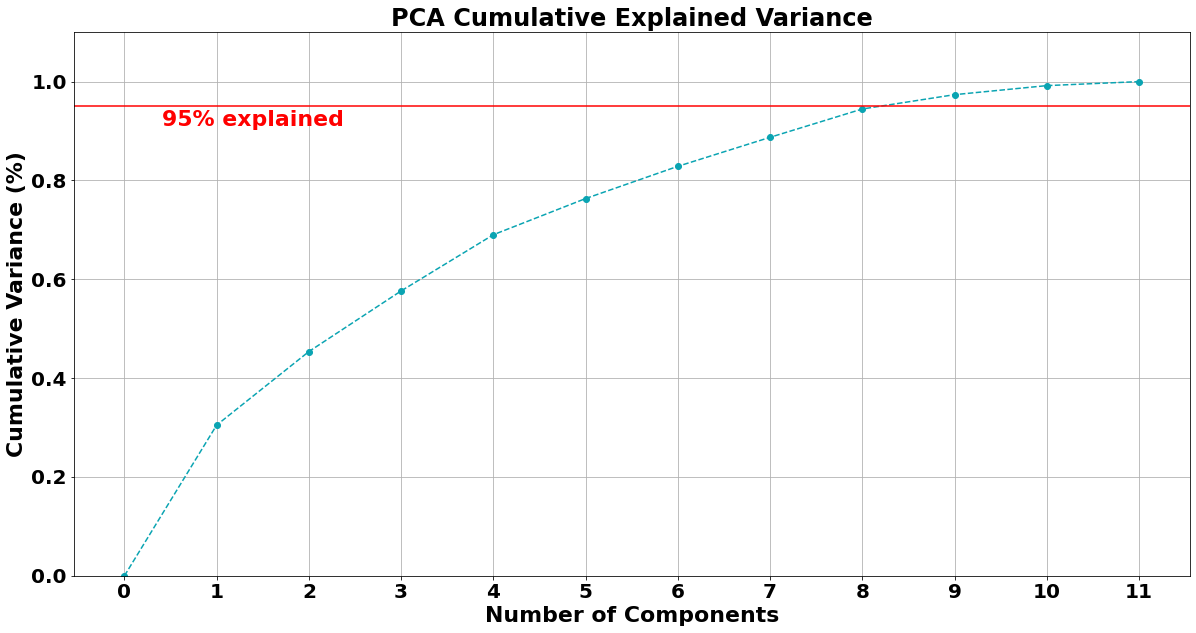

In [26]:
# Determine number of PCA components
pca_sentiment = PCA(11, random_state=rs).fit(sentiment_cluster_data_st) # include number of features for test

# Plot PCA components and cumulative explained variance
fig, ax = plt.subplots(figsize=(20, 10))
x = np.arange(0, 12, step=1)
y = np.cumsum(np.insert(pca_sentiment.explained_variance_ratio_, 0, 0))

plt.ylim(0.0,1.1)
plt.plot(x, y, marker='o', linestyle='--', color='#0AA4B2')

plt.xlabel('Number of Components', fontsize=22, color='black', fontweight='bold')
plt.xticks(np.arange(0, 12, step=1), fontsize=20, color='black', fontweight='bold') #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative Variance (%)', fontsize=22, color='black', fontweight='bold')
plt.yticks(fontsize=20, color='black', fontweight='bold')
plt.title('PCA Cumulative Explained Variance', fontsize=24, fontweight='bold')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.41, 0.91, '95% explained', color = 'red', fontsize=22, fontweight='bold')

ax.grid(axis='x')
ax.grid(axis='y')
#fig.savefig('pca_variance.png')
plt.show()


In [27]:
# Display variance explained in a dataframe
pd.DataFrame({'Components' : x, 'Cum. Variance' : y}).sort_values('Components', ascending=False)

Components  Cum. Variance
11          11       1.000000
10          10       0.991889
9            9       0.973590
8            8       0.944603
7            7       0.887285
6            6       0.828587
5            5       0.763378
4            4       0.690171
3            3       0.576435
2            2       0.453769
1            1       0.304940
0            0       0.000000

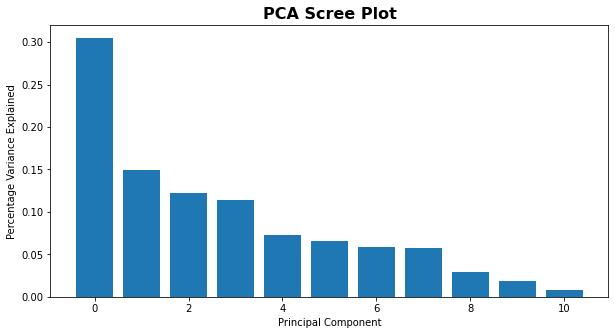

In [28]:
# Display Scree plot
fig, ax = plt.subplots(figsize=(10,5))
x = np.arange(0, 11, step=1)
y = pca_sentiment.explained_variance_ratio_

plt.bar(x, y)
plt.title('PCA Scree Plot', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Percentage Variance Explained')
plt.show()

In [29]:
# Display variance explained in a dataframe
pd.DataFrame({'Components' : x, 'Variance Explained' : y}).sort_values('Components')

Components  Variance Explained
0            0            0.304940
1            1            0.148829
2            2            0.122667
3            3            0.113736
4            4            0.073206
5            5            0.065209
6            6            0.058698
7            7            0.057318
8            8            0.028988
9            9            0.018299
10          10            0.008111

#### *Run PCA Transformation*

In [30]:
# Rebuild PCA witth chosen number of components
pca_sentiment = PCA(8, random_state=rs)

#Transform the clustering data
sentiment_cluster_data_pca = pca_sentiment.fit_transform(sentiment_cluster_data_st)

#### *Choose Number of K-Means Clusters*

Clusters =  2 :  Silhouette Score =  0.26646370274048586
Clusters =  3 :  Silhouette Score =  0.14078691762315704
Clusters =  4 :  Silhouette Score =  0.14666457772567376
Clusters =  5 :  Silhouette Score =  0.1404020379085803
Clusters =  6 :  Silhouette Score =  0.13786614468577615
Clusters =  7 :  Silhouette Score =  0.1369561021064221
Clusters =  8 :  Silhouette Score =  0.12614769535388773
Clusters =  9 :  Silhouette Score =  0.13449820055191833
Clusters =  10 :  Silhouette Score =  0.1335606270243689
Clusters =  11 :  Silhouette Score =  0.11797951448073012
Clusters =  12 :  Silhouette Score =  0.11997262994709214
Clusters =  13 :  Silhouette Score =  0.12312653657099794
Clusters =  14 :  Silhouette Score =  0.12362695673315657
Clusters =  15 :  Silhouette Score =  0.11715193206603294
Clusters =  16 :  Silhouette Score =  0.10798782677127948
Clusters =  17 :  Silhouette Score =  0.1142642371195118
Clusters =  18 :  Silhouette Score =  0.10978660805485796
Clusters =  19 :  Silhouet

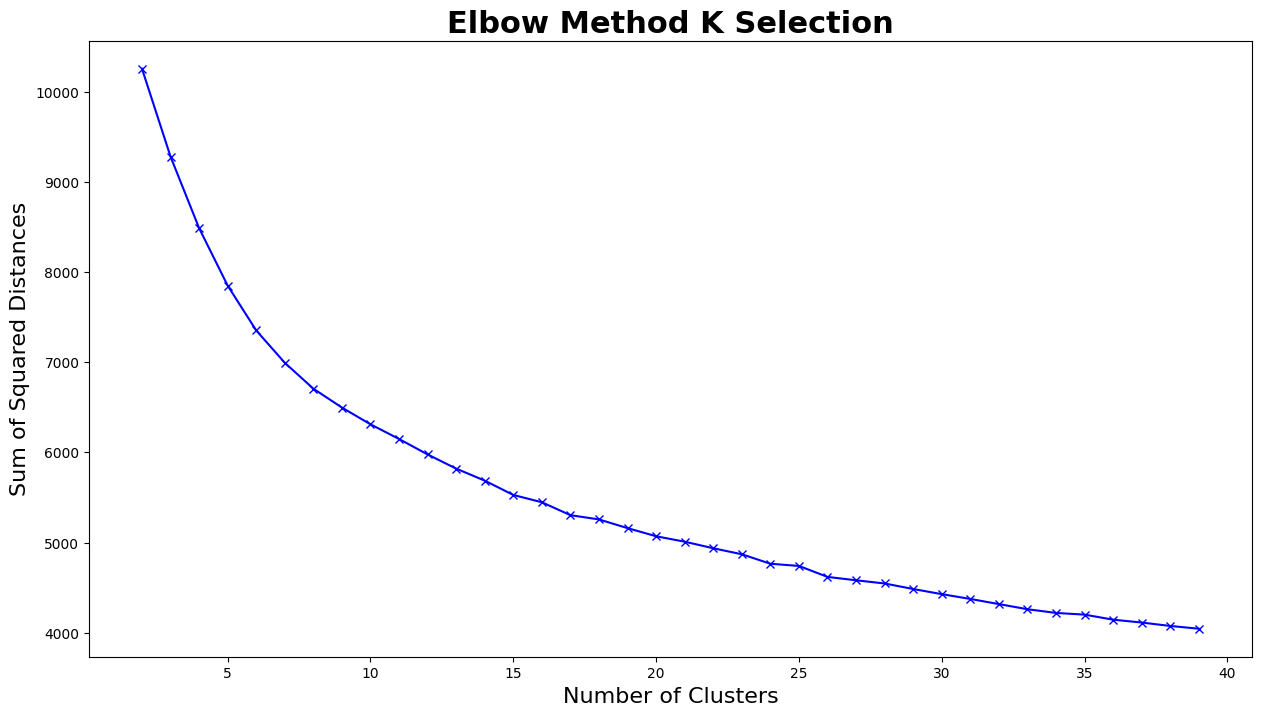

In [136]:
sum_of_squared_distances = []
for i in range(2,40):
    km = KMeans(n_clusters=i, random_state=rs)
    prediction = km.fit_predict(sentiment_cluster_data_pca)
    
    silhouette = silhouette_score(sentiment_cluster_data_pca, prediction, random_state=rs)
    print ('Clusters = ', i, ':  Silhouette Score = ', silhouette)
    
    sum_of_squared_distances.append(km.inertia_)

fig = plt.figure(figsize=(15, 8))
plt.plot(range(2,40), sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Sum of Squared Distances', fontsize=16)
plt.title('Elbow Method K Selection', fontsize=22, fontweight='bold')
plt.show()

#### *Generate K-Means Clusters (K=9)*

In [32]:
# Create K-Means model and make predictions
km = KMeans(n_clusters=9, random_state=rs)
y_predicted = km.fit_predict(sentiment_cluster_data_pca)

In [33]:
# Add predictions to the data and show mean for each cluster and feature combination
sentiment_cluster_data['cluster_kmeans_9'] = y_predicted
sentiment_cluster_data.groupby('cluster_kmeans_9').mean()

nupl  active_addresses_vs_ath  net_transfer_volume  \
cluster_kmeans_9                                                           
0                 0.016556                 0.499358           353.477044   
1                 0.661030                 0.839937         -1336.722415   
2                 0.180814                 0.510261            23.604366   
3                 0.434886                 0.706221         -2476.634540   
4                 0.322125                 0.637963          5946.398808   
5                 0.569844                 0.808228         13399.534837   
6                 0.264548                 0.533858          1001.370785   
7                 0.322227                 0.584298           153.550788   
8                 0.395582                 0.541261          2059.423605   

                  volume_vs_ath  closing_price_vs_ath  article_polarity  \
cluster_kmeans_9                                                          
0                      0.062760              0.261766          0.065582   
1                      0.128341              0.909623          0.087502   
2                      0.053849              0.344419          0.085393   
3                      0.077431              0.547130          0.077327   
4                      0.250096              0.442407          0.085805   
5                      0.265374              0.704743          0.086103   
6                      0.066942              0.387275          0.112032   
7                      0.066453              0.423227          0.086278   
8                      0.104680              0.456395          0.086811   

                  article_subjectivity  reddit_polarity  reddit_subjectivity  \
cluster_kmeans_9                                                               
0                             0.383708         0.063886             0.361640   
1                             0.413537         0.087133             0.367173   
2                             0.405997         0.166831             0.416909   
3                             0.409067         0.099910             0.377673   
4                             0.412672         0.074488             0.372529   
5                             0.415502         0.067799             0.396842   
6                             0.436983         0.085935             0.359099   
7                             0.408166         0.049212             0.290194   
8                             0.409909         0.073341             0.355591   

                  interest_vs_all_time_median  num_comments_vs_ath  
cluster_kmeans_9                                                    
0                                    2.418960             0.078799  
1                                    4.385704             0.306657  
2                                    2.025779             0.059813  
3                                    1.719683             0.086028  
4                                    2.855748             0.229449  
5                                   10.475505             0.838820  
6                                    2.648972             0.086562  
7                                    2.024410             0.079867  
8                                    6.821029             0.239273

In [34]:
# Show cluster counts
sentiment_cluster_data.groupby('cluster_kmeans_9')[['nupl']].count()

nupl
cluster_kmeans_9      
0                  151
1                  171
2                  133
3                  221
4                   59
5                   41
6                  168
7                  207
8                  113

#### *Visualize K-Means Clusters (K=9)*

In [35]:
x = sentiment_cluster_data_pca[:, 0]
y = sentiment_cluster_data_pca[:, 1]
z = sentiment_cluster_data_pca[:, 2]

colors = {0 : 'red',
          1 : 'green',
          2 : 'blue',
          3 : 'aqua',
          4 : 'purple',
          5 : 'orange',
          6 : 'pink',
          7 : 'brown',
          8 : 'gray'
         }

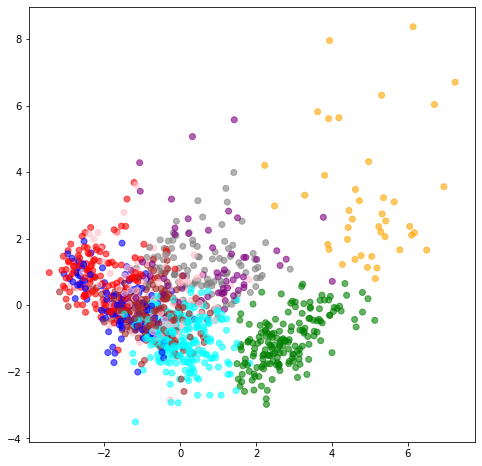

In [36]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(x, y, c=pd.Series(y_predicted).map(colors), alpha=0.6)
plt.show()

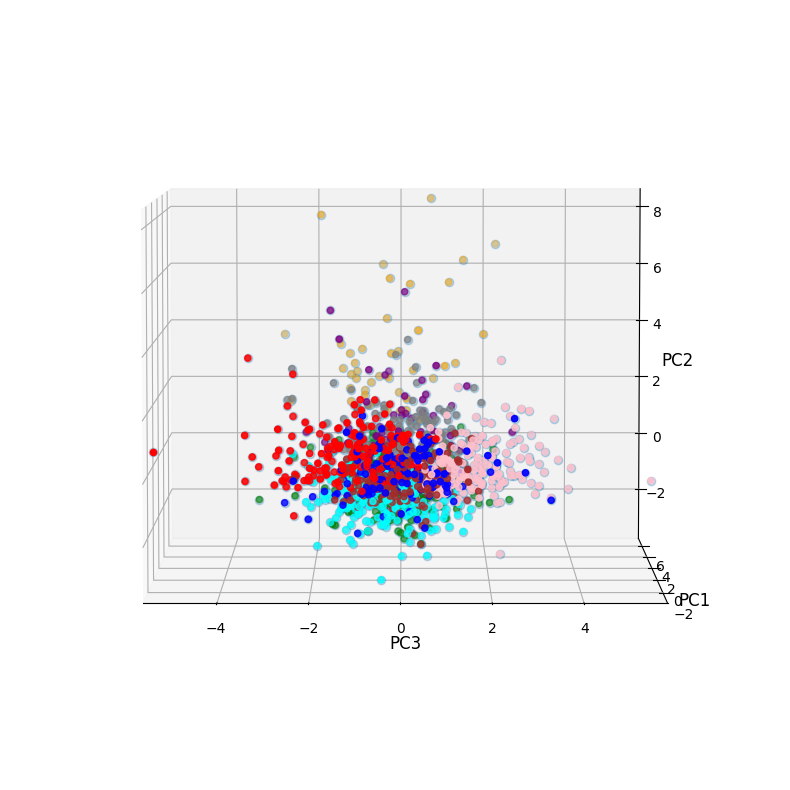

In [37]:
# Plot 3D projection
plt.style.use('default')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(z, x, y, linestyle='none', marker='o', alpha=0.25)
ax.scatter(z, x, y, c=pd.Series(y_predicted).map(colors))
ax.set_xlabel('PC3', fontsize=12)
ax.set_ylabel('PC1', fontsize=12)
ax.set_zlabel('PC2', fontsize=12)
ax.axes.set_xlim3d(left=z.min(), right=z.max()) 
ax.axes.set_ylim3d(bottom=x.min(), top=x.max()) 
ax.axes.set_zlim3d(bottom=y.min(), top=y.max()) 
ax.view_init(elev=5, azim=270)#, azim=0)

fig.tight_layout()

#### *Generate K-Means Clusters (K=6)*

In [38]:
# Create K-Means model and make predictions
km = KMeans(n_clusters=6, random_state=rs)
y_predicted = km.fit_predict(sentiment_cluster_data_pca)

In [39]:
# Add predictions to the data and show mean for each cluster and feature combination
sentiment_cluster_data['cluster_kmeans_6'] = y_predicted
sentiment_cluster_data.groupby('cluster_kmeans_6').mean()

nupl  active_addresses_vs_ath  net_transfer_volume  \
cluster_kmeans_6                                                           
0                 0.635867                 0.816335         -1004.757286   
1                 0.275019                 0.526331          1799.326914   
2                 0.319263                 0.599713         -1264.320669   
3                 0.518283                 0.760899         12983.121023   
4                 0.380968                 0.637966          -937.345022   
5                 0.031075                 0.495702          1178.178283   

                  volume_vs_ath  closing_price_vs_ath  article_polarity  \
cluster_kmeans_6                                                          
0                      0.130025              0.857951          0.087224   
1                      0.080946              0.389752          0.106863   
2                      0.064154              0.439811          0.082536   
3                      0.275163              0.652835          0.087496   
4                      0.083516              0.476205          0.080456   
5                      0.069555              0.267785          0.067593   

                  article_subjectivity  reddit_polarity  reddit_subjectivity  \
cluster_kmeans_6                                                               
0                             0.412908         0.087859             0.372386   
1                             0.430572         0.081172             0.349843   
2                             0.410018         0.149292             0.411075   
3                             0.413685         0.066182             0.390760   
4                             0.406580         0.057363             0.316517   
5                             0.385696         0.070943             0.364811   

                  interest_vs_all_time_median  num_comments_vs_ath  \
cluster_kmeans_6                                                     
0                                    4.525660             0.289663   
1                                    3.532673             0.119986   
2                                    1.771026             0.066619   
3                                    9.189040             0.743596   
4                                    2.211236             0.100112   
5                                    2.663734             0.089468   

                  cluster_kmeans_9  
cluster_kmeans_6                    
0                         1.814286  
1                         6.260536  
2                         2.715556  
3                         5.054545  
4                         5.598131  
5                         1.046875

In [41]:
# Show cluster counts
sentiment_cluster_data.groupby('cluster_kmeans_6')[['nupl']].count()

nupl
cluster_kmeans_6      
0                  210
1                  261
2                  225
3                   55
4                  321
5                  192

#### *Visualize K-Means Clusters (K=6)*

In [42]:
x = sentiment_cluster_data_pca[:, 0]
y = sentiment_cluster_data_pca[:, 1]
z = sentiment_cluster_data_pca[:, 2]

colors = {0 : 'green',
          1 : 'purple',
          2 : 'aqua',
          3 : 'blue',
          4 : 'orange',
          5 : 'red',
          6 : 'pink',
          7 : 'brown',
          8 : 'gray'
         }

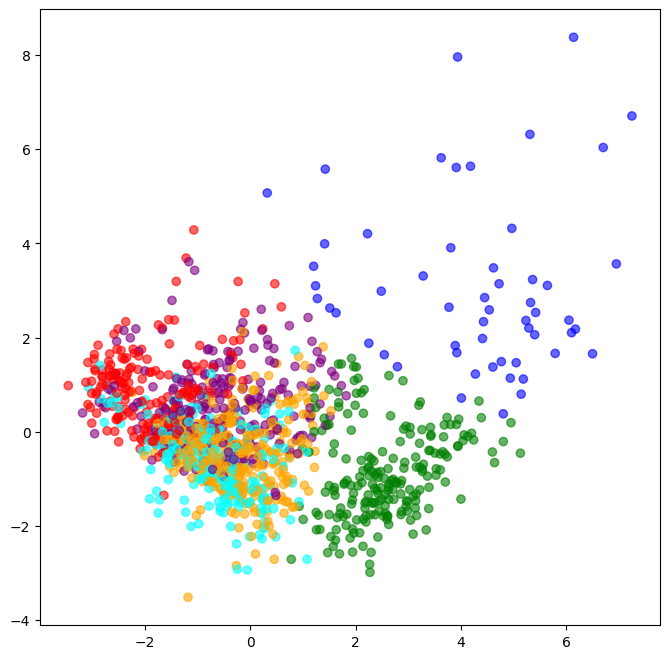

In [43]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(x, y, c=pd.Series(y_predicted).map(colors), alpha=0.6)
plt.show()

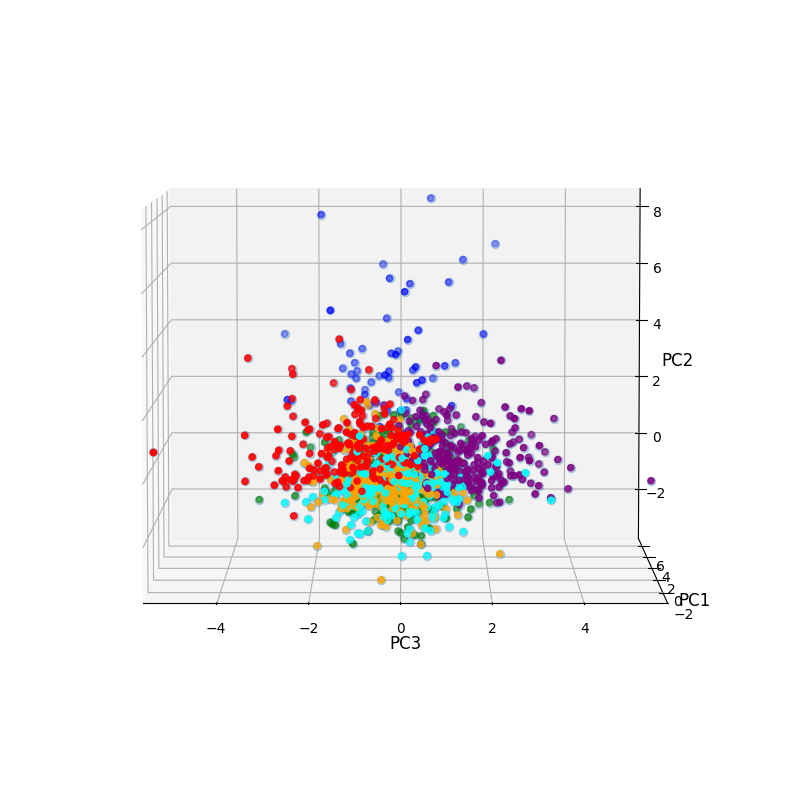

In [44]:
# Plot 3D projection
plt.style.use('default')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(z, x, y, linestyle='none', marker='o', alpha=0.25)
ax.scatter(z, x, y, c=pd.Series(y_predicted).map(colors))
ax.set_xlabel('PC3', fontsize=12)
ax.set_ylabel('PC1', fontsize=12)
ax.set_zlabel('PC2', fontsize=12)
ax.axes.set_xlim3d(left=z.min(), right=z.max()) 
ax.axes.set_ylim3d(bottom=x.min(), top=x.max()) 
ax.axes.set_zlim3d(bottom=y.min(), top=y.max()) 
ax.view_init(elev=5, azim=270)#, azim=0)

fig.tight_layout()

#### *Generate DBSCAN Clusters*

In [45]:
# Create DBSCAN model and make predictions
dbscan = DBSCAN(eps=1.15)
y_predicted = dbscan.fit_predict(sentiment_cluster_data_pca)

In [46]:
# Add predictions to the data and show mean for each cluster and feature combination
sentiment_cluster_data['cluster_dbscan'] = y_predicted
sentiment_cluster_data.groupby('cluster_dbscan').mean()

nupl  active_addresses_vs_ath  net_transfer_volume  \
cluster_dbscan                                                           
-1              0.329125                 0.616099           613.282668   
 0              0.330356                 0.601557           235.203953   
 1              0.657197                 0.841749           336.775754   
 2              0.586208                 0.831900         -3124.864538   
 3              0.714133                 0.860426          2356.878292   
 4              0.692786                 0.824218         -1242.642268   

                volume_vs_ath  closing_price_vs_ath  article_polarity  \
cluster_dbscan                                                          
-1                   0.105751              0.486677          0.085847   
 0                   0.061034              0.437954          0.084925   
 1                   0.112187              0.920039          0.094268   
 2                   0.060928              0.923064          0.077543   
 3                   0.147113              0.947765          0.078875   
 4                   0.117343              0.908242          0.075353   

                article_subjectivity  reddit_polarity  reddit_subjectivity  \
cluster_dbscan                                                               
-1                          0.410364         0.084179             0.363049   
 0                          0.410069         0.091481             0.352273   
 1                          0.409975         0.078596             0.368466   
 2                          0.432939         0.086385             0.323651   
 3                          0.409876         0.097409             0.387944   
 4                          0.403254         0.099820             0.340530   

                interest_vs_all_time_median  num_comments_vs_ath  \
cluster_dbscan                                                     
-1                                 3.631883             0.184387   
 0                                 1.911259             0.073966   
 1                                 3.761576             0.229076   
 2                                 2.117364             0.150287   
 3                                 5.979027             0.431021   
 4                                 4.881244             0.297879   

                cluster_kmeans_9  cluster_kmeans_6  
cluster_dbscan                                      
-1                      3.927739          2.376457  
 0                      4.184136          3.062323  
 1                      1.051282          0.000000  
 2                      1.000000          0.000000  
 3                      1.000000          0.000000  
 4                      1.000000          0.000000

In [47]:
# Show cluster counts
sentiment_cluster_data.groupby('cluster_dbscan')[['nupl']].count()

nupl
cluster_dbscan      
-1               858
 0               353
 1                39
 2                 5
 3                 5
 4                 4

In [48]:
y_predicted

array([-1, -1, -1, ...,  0, -1,  0])

#### *Visualize DBSCAN Clusters*

In [49]:
x = sentiment_cluster_data_pca[:, 0]
y = sentiment_cluster_data_pca[:, 1]
z = sentiment_cluster_data_pca[:, 2]

colors = {-1 : 'red',
          0 : 'green',
          1 : 'blue',
          2 : 'aqua',
          3 : 'purple',
          4 : 'orange'
         }

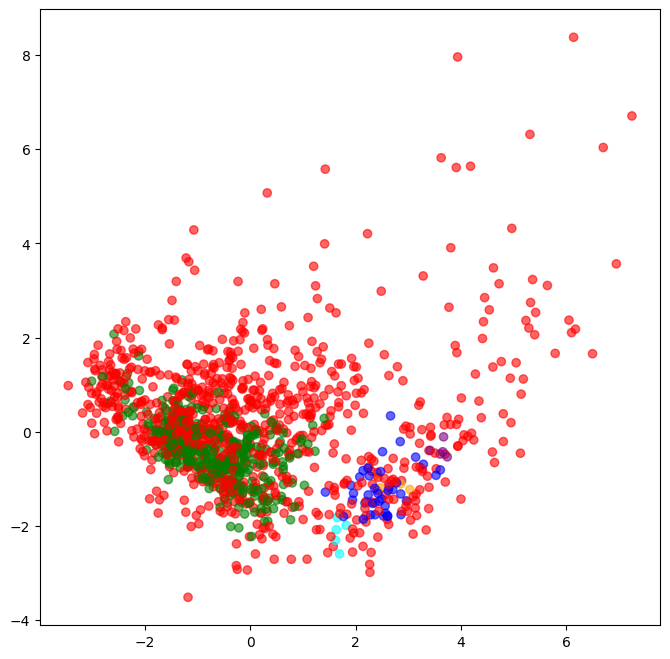

In [50]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(x, y, c=pd.Series(y_predicted).map(colors), alpha=0.6)
plt.show()

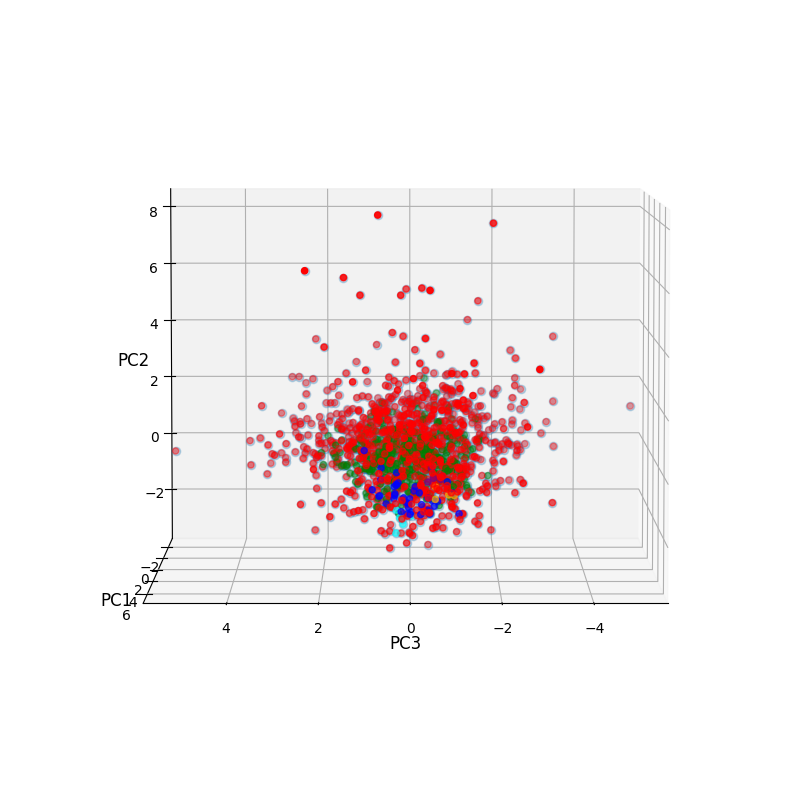

In [51]:
# Plot 3D projection
plt.style.use('default')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(z, x, y, linestyle='none', marker='o', alpha=0.25)
ax.scatter(z, x, y, c=pd.Series(y_predicted).map(colors))
ax.set_xlabel('PC3', fontsize=12)
ax.set_ylabel('PC1', fontsize=12)
ax.set_zlabel('PC2', fontsize=12)
ax.axes.set_xlim3d(left=z.min(), right=z.max()) 
ax.axes.set_ylim3d(bottom=x.min(), top=x.max()) 
ax.axes.set_zlim3d(bottom=y.min(), top=y.max()) 
ax.view_init(elev=5, azim=90)#, azim=0)

fig.tight_layout()

#### *Generate HDBSCAN Clusters*

In [128]:
# Create DBSCAN model and make predictions
hdbscan_1 = hdbscan.HDBSCAN()
y_predicted = hdbscan_1.fit(sentiment_cluster_data_pca).labels_

In [129]:
# Add predictions to the data and show mean for each cluster and feature combination
sentiment_cluster_data['cluster_hdbscan'] = y_predicted
sentiment_cluster_data.groupby('cluster_hdbscan').mean()

nupl  active_addresses_vs_ath  net_transfer_volume  \
cluster_hdbscan                                                           
-1               0.341752                 0.625898           582.933938   
 0               0.321430                 0.593501           295.853418   
 1               0.704495                 0.861005          -558.716465   
 2               0.658711                 0.853085           289.572034   

                 volume_vs_ath  closing_price_vs_ath  article_polarity  \
cluster_hdbscan                                                          
-1                    0.106833              0.501644          0.086143   
 0                    0.062870              0.434447          0.084451   
 1                    0.134930              0.946468          0.078652   
 2                    0.101565              0.923082          0.094067   

                 article_subjectivity  reddit_polarity  reddit_subjectivity  \
cluster_hdbscan                                                               
-1                           0.410940         0.084434             0.364271   
 0                           0.408913         0.090413             0.350626   
 1                           0.406228         0.104181             0.355915   
 2                           0.412390         0.075741             0.363552   

                 interest_vs_all_time_median  num_comments_vs_ath  \
cluster_hdbscan                                                     
-1                                  3.666347             0.189145   
 0                                  1.981119             0.075600   
 1                                  5.540605             0.314374   
 2                                  3.707621             0.238839   

                 cluster_kmeans_9  cluster_kmeans_6  cluster_dbscan  \
cluster_hdbscan                                                       
-1                       3.882353          2.272941       -0.877647   
 0                       4.093750          3.093750       -0.184896   
 1                       1.000000          0.000000        3.200000   
 2                       1.000000          0.000000        0.920000   

                 cluster_gaussian  cluster_hac  
cluster_hdbscan                                 
-1                       2.376471     2.020000  
 0                       2.966146     2.221354  
 1                       0.000000     3.000000  
 2                       0.000000     3.000000

In [130]:
# Show cluster counts
sentiment_cluster_data.groupby('cluster_hdbscan')[['nupl']].count()

nupl
cluster_hdbscan      
-1                850
 0                384
 1                  5
 2                 25

In [131]:
y_predicted

array([-1, -1, -1, ...,  0, -1,  0])

#### *Visualize HDBSCAN Clusters*

In [132]:
x = sentiment_cluster_data_pca[:, 0]
y = sentiment_cluster_data_pca[:, 1]
z = sentiment_cluster_data_pca[:, 2]

colors = {-1 : 'red',
          0 : 'green',
          1 : 'blue',
          2 : 'aqua',
          3 : 'purple',
          4 : 'orange'
         }

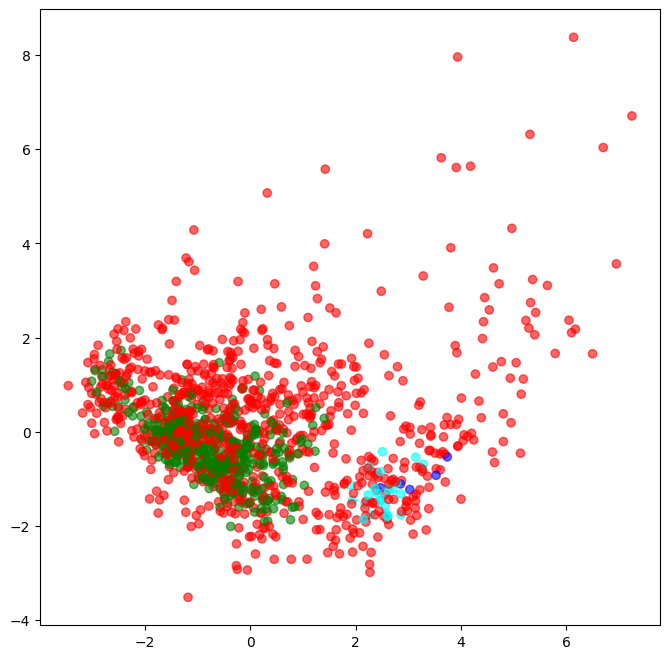

In [133]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(x, y, c=pd.Series(y_predicted).map(colors), alpha=0.6)
plt.show()

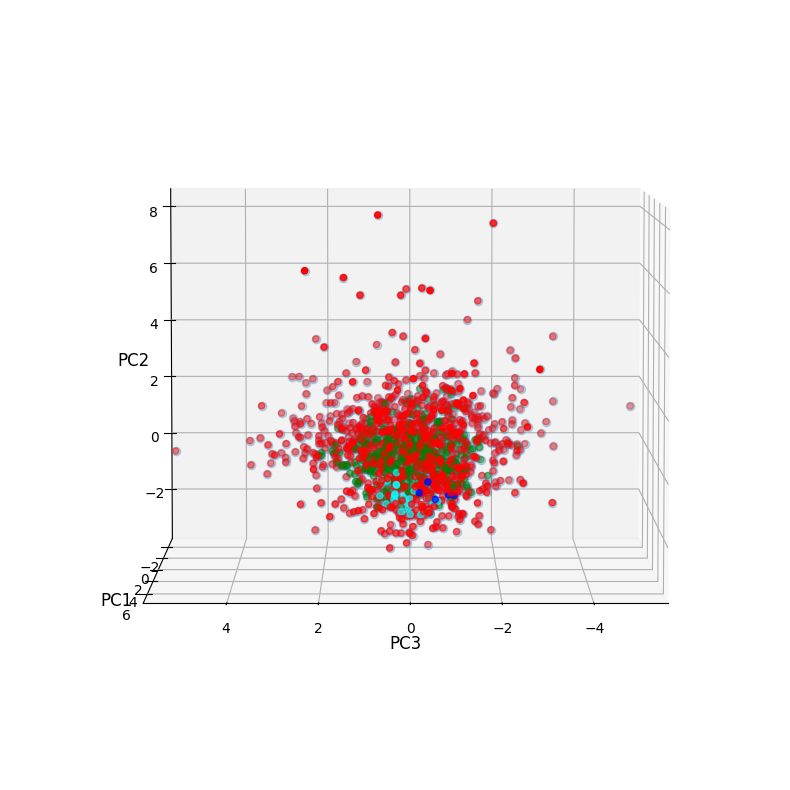

In [134]:
# Plot 3D projection
plt.style.use('default')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(z, x, y, linestyle='none', marker='o', alpha=0.25)
ax.scatter(z, x, y, c=pd.Series(y_predicted).map(colors))
ax.set_xlabel('PC3', fontsize=12)
ax.set_ylabel('PC1', fontsize=12)
ax.set_zlabel('PC2', fontsize=12)
ax.axes.set_xlim3d(left=z.min(), right=z.max()) 
ax.axes.set_ylim3d(bottom=x.min(), top=x.max()) 
ax.axes.set_zlim3d(bottom=y.min(), top=y.max()) 
ax.view_init(elev=5, azim=90)#, azim=0)

fig.tight_layout()

In [135]:
# Create 360 images for GIF
for i in np.arange(0, 360, 1):
    ax.view_init(elev=5, azim=i)
    fig.savefig('hdbscan_'+str(i)+'.png')

#### *Generate Gaussian Mixture Clusters*

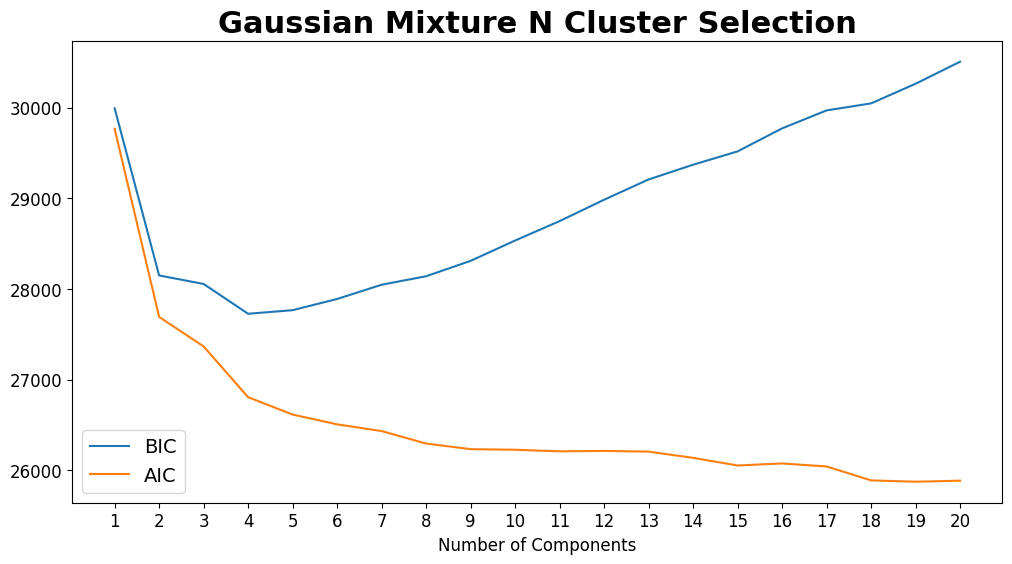

In [141]:
# Determine optimal number of clusters
fig = plt.figure(figsize=(12, 6))
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=rs).fit(sentiment_cluster_data_pca) for n in n_components]
plt.plot(n_components, [m.bic(sentiment_cluster_data_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(sentiment_cluster_data_pca) for m in models], label='AIC')
plt.legend(loc='best', fontsize=14)
plt.title('Gaussian Mixture N Cluster Selection', fontsize=22, fontweight='bold')
plt.xlabel('Number of Components', fontsize=12)
plt.xticks(np.arange(1,21), fontsize=12)
plt.yticks(fontsize=12);

In [60]:
# Create Gaussian Mixture model and make predictions
gm = GaussianMixture(n_components=6, random_state=rs)
y_predicted = gm.fit_predict(sentiment_cluster_data_pca)

In [61]:
# Add predictions to the data and show mean for each cluster and feature combination
sentiment_cluster_data['cluster_gaussian'] = y_predicted
sentiment_cluster_data.groupby('cluster_gaussian').mean()

nupl  active_addresses_vs_ath  net_transfer_volume  \
cluster_gaussian                                                           
0                 0.661311                 0.841168          -661.056105   
1                 0.350069                 0.513751          1528.861126   
2                 0.320225                 0.618352          -840.488485   
3                 0.385864                 0.675763          3081.376833   
4                 0.393261                 0.632845          1052.125002   
5                 0.011295                 0.472977           513.227088   

                  volume_vs_ath  closing_price_vs_ath  article_polarity  \
cluster_gaussian                                                          
0                      0.117390              0.920186          0.086532   
1                      0.080727              0.419264          0.092737   
2                      0.051622              0.438020          0.084583   
3                      0.218230              0.532829          0.085408   
4                      0.108675              0.485068          0.085380   
5                      0.049713              0.262451          0.081908   

                  article_subjectivity  reddit_polarity  reddit_subjectivity  \
cluster_gaussian                                                               
0                             0.411908         0.088757             0.366962   
1                             0.414621         0.077634             0.347071   
2                             0.412356         0.102638             0.365476   
3                             0.411933         0.075107             0.378720   
4                             0.409662         0.077316             0.342633   
5                             0.400156         0.076140             0.358547   

                  interest_vs_all_time_median  num_comments_vs_ath  \
cluster_gaussian                                                     
0                                    4.117687             0.288671   
1                                    5.509709             0.184312   
2                                    1.392602             0.049505   
3                                    6.026218             0.409212   
4                                    2.125182             0.117174   
5                                    2.687404             0.069270   

                  cluster_kmeans_9  cluster_kmeans_6  cluster_dbscan  \
cluster_gaussian                                                       
0                         1.160494          0.086420       -0.191358   
1                         6.580838          2.185629       -0.922156   
2                         3.987113          2.801546       -0.507732   
3                         4.238710          2.374194       -0.987097   
4                         4.684211          2.971292       -0.540670   
5                         2.360656          3.633880       -0.710383   

                  cluster_hdbscan  
cluster_gaussian                   
0                       -0.469136  
1                       -0.874251  
2                       -0.497423  
3                       -1.000000  
4                       -0.488038  
5                       -0.672131

In [62]:
# Show cluster counts
sentiment_cluster_data.groupby('cluster_gaussian')[['nupl']].count()

nupl
cluster_gaussian      
0                  162
1                  167
2                  388
3                  155
4                  209
5                  183

#### *Visualize Gaussian Mixture Clusters*

In [63]:
x = sentiment_cluster_data_pca[:, 0]
y = sentiment_cluster_data_pca[:, 1]
z = sentiment_cluster_data_pca[:, 2]

colors = {0 : 'green',
          1 : 'orange',
          2 : 'aqua',
          3 : 'blue',
          4 : 'purple',
          5 : 'red'
         }

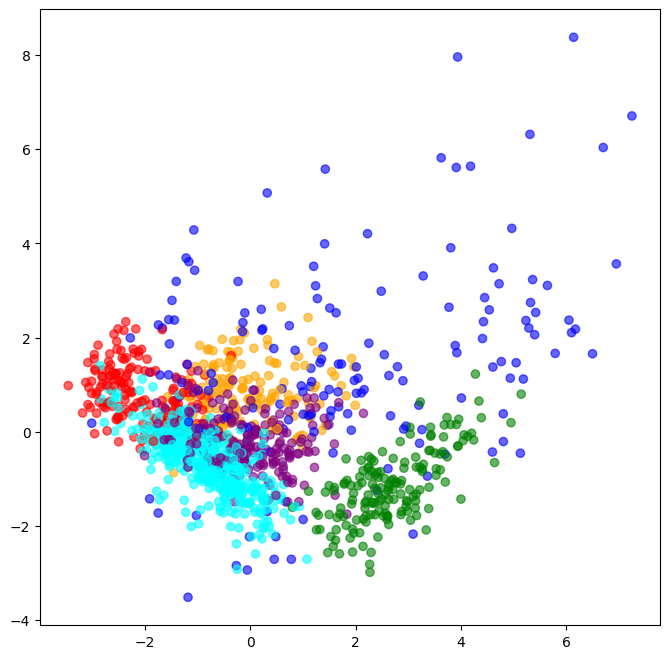

In [64]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(x, y, c=pd.Series(y_predicted).map(colors), alpha=0.6)
plt.show()

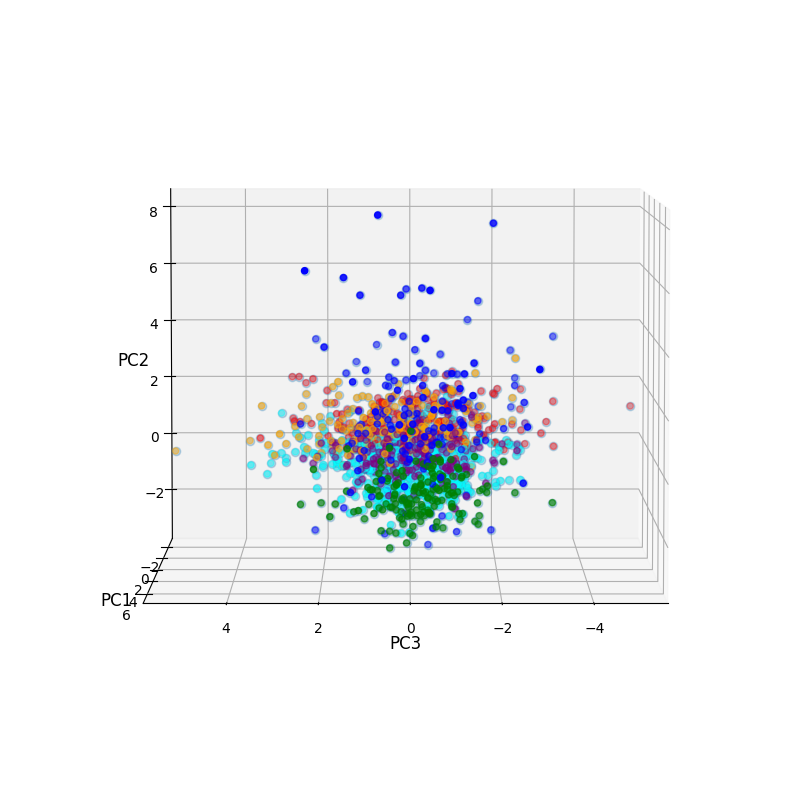

In [65]:
# Plot 3D projection
plt.style.use('default')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(z, x, y, linestyle='none', marker='o', alpha=0.25)
ax.scatter(z, x, y, c=pd.Series(y_predicted).map(colors))
ax.set_xlabel('PC3', fontsize=12)
ax.set_ylabel('PC1', fontsize=12)
ax.set_zlabel('PC2', fontsize=12)
ax.axes.set_xlim3d(left=z.min(), right=z.max()) 
ax.axes.set_ylim3d(bottom=x.min(), top=x.max()) 
ax.axes.set_zlim3d(bottom=y.min(), top=y.max()) 
ax.view_init(elev=5, azim=90)#, azim=0)

fig.tight_layout()

#### *Generate Hierarchical Agglomerative Clusters (HAC)*

In [118]:
# Create Gaussian Mixture model and make predictions
from sklearn.cluster import AgglomerativeClustering

hac = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
y_predicted = hac.fit_predict(sentiment_cluster_data_pca)

In [119]:
# Add predictions to the data and show mean for each cluster and feature combination
sentiment_cluster_data['cluster_hac'] = y_predicted
sentiment_cluster_data.groupby('cluster_hac').mean()

nupl  active_addresses_vs_ath  net_transfer_volume  \
cluster_hac                                                           
0            0.151961                 0.534391            -6.300466   
1            0.388555                 0.602588          4149.496175   
2            0.357995                 0.629853          -761.577834   
3            0.661517                 0.840328         -1130.112656   
4            0.594200                 0.830753         14290.017202   
5            0.324308                 0.568819            -8.343978   

             volume_vs_ath  closing_price_vs_ath  article_polarity  \
cluster_hac                                                          
0                 0.058688              0.338464          0.074539   
1                 0.172481              0.473115          0.086863   
2                 0.084863              0.470366          0.097408   
3                 0.131379              0.916836          0.086317   
4                 0.219921              0.729997          0.088239   
5                 0.068115              0.421184          0.086805   

             article_subjectivity  reddit_polarity  reddit_subjectivity  \
cluster_hac                                                               
0                        0.395715         0.098809             0.384968   
1                        0.403800         0.075190             0.369512   
2                        0.424853         0.104431             0.369047   
3                        0.412696         0.089153             0.366374   
4                        0.416516         0.069313             0.395168   
5                        0.415335         0.052340             0.299458   

             interest_vs_all_time_median  num_comments_vs_ath  \
cluster_hac                                                     
0                               2.152808             0.069804   
1                               5.615437             0.278396   
2                               2.367017             0.101865   
3                               4.170655             0.301312   
4                              11.442647             0.852960   
5                               2.447651             0.087006   

             cluster_kmeans_9  cluster_kmeans_6  cluster_dbscan  \
cluster_hac                                                       
0                    2.172603          3.484932       -0.715068   
1                    5.884058          2.210145       -0.992754   
2                    4.406667          2.080000       -0.530000   
3                    1.165714          0.102857       -0.240000   
4                    5.000000          3.000000       -1.000000   
5                    6.347826          3.169960       -0.577075   

             cluster_hdbscan  cluster_gaussian  
cluster_hac                                     
0                  -0.654795          3.345205  
1                  -0.963768          2.347826  
2                  -0.536667          2.633333  
3                  -0.514286          0.314286  
4                  -1.000000          2.818182  
5                  -0.549407          2.671937

In [120]:
# Show cluster counts
sentiment_cluster_data.groupby('cluster_hac')[['nupl']].count()

nupl
cluster_hac      
0             365
1             138
2             300
3             175
4              33
5             253

#### *Visualize Hierarchical Agglomerative Clusters*

In [121]:
x = sentiment_cluster_data_pca[:, 0]
y = sentiment_cluster_data_pca[:, 1]
z = sentiment_cluster_data_pca[:, 2]

colors = {0 : 'red',
          1 : 'orange',
          2 : 'purple',
          3 : 'green',
          4 : 'blue',
          5 : 'aqua'
         }

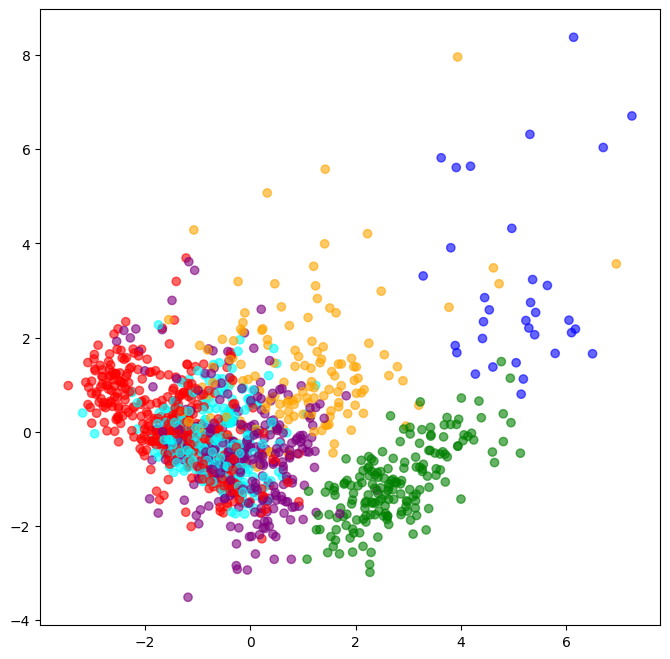

In [122]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(x, y, c=pd.Series(y_predicted).map(colors), alpha=0.6)
plt.show()

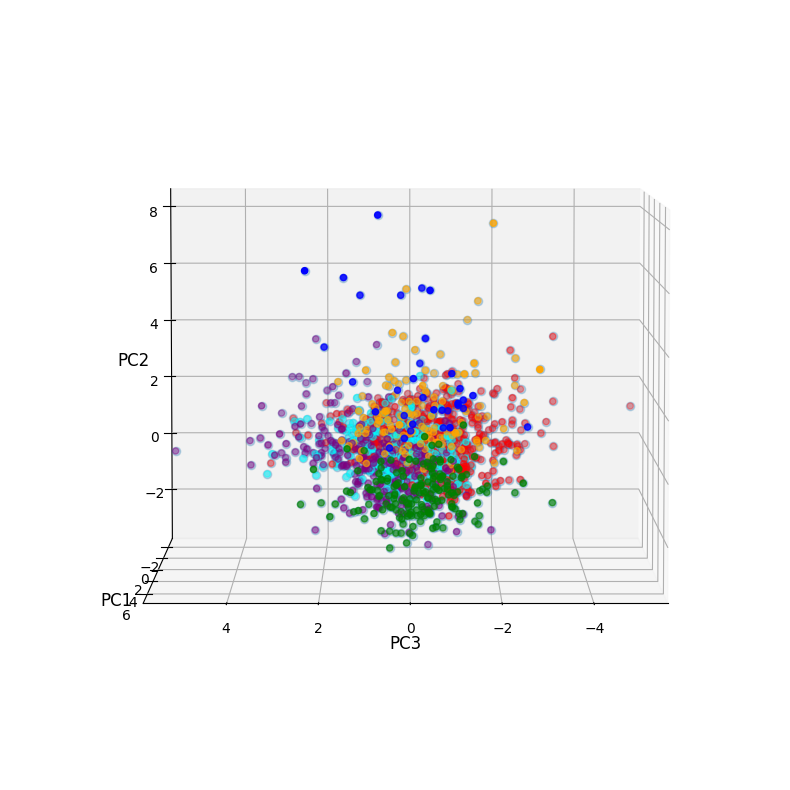

In [123]:
# Plot 3D projection
plt.style.use('default')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(z, x, y, linestyle='none', marker='o', alpha=0.25)
ax.scatter(z, x, y, c=pd.Series(y_predicted).map(colors))
ax.set_xlabel('PC3', fontsize=12)
ax.set_ylabel('PC1', fontsize=12)
ax.set_zlabel('PC2', fontsize=12)
ax.axes.set_xlim3d(left=z.min(), right=z.max()) 
ax.axes.set_ylim3d(bottom=x.min(), top=x.max()) 
ax.axes.set_zlim3d(bottom=y.min(), top=y.max()) 
ax.view_init(elev=5, azim=90)#, azim=0)

fig.tight_layout()

In [124]:
# Create 360 images for GIF
for i in np.arange(0, 360, 1):
    ax.view_init(elev=5, azim=i)
    fig.savefig('hac_'+str(i)+'.png')

## One vs. Rest Plots - K-Means - 6 Clusters

In [73]:
def one_vs_rest_kde(data, cluster_col, cluster_val, viz_cols, title):
    """
    Accept a dataset (cluster column LAST) and a cluster value.
    Display one vs. rest distributions for all metrics in the data.
    """
    
    cols = data.columns[:-1]
    viz_rows = ceil(len(cols) / viz_cols)
    
    data[cluster_col] = np.where(data[cluster_col] == cluster_val, str(cluster_val), 'REST')
    
    fig, axes = plt.subplots(viz_rows, viz_cols, figsize=[16, viz_rows * 3])
    fig.tight_layout(pad=5.0)
    fig.suptitle(title, fontsize=22, fontweight='bold')
    fig.subplots_adjust(top=0.9)

    for i in range(len(cols)):
        plt.subplot(viz_rows, viz_cols, i + 1)
        sns.kdeplot(data=data, x=cols[i], hue=cluster_col, common_norm=True, 
                    hue_order=['REST', str(cluster_val)])
        plt.title(cols[i])

In [74]:
def one_vs_rest_table(data, cluster_col, cluster_val):
    """
    Accept a dataset (cluster column LAST) and a cluster value.
    Display one vs. rest describe tables for all metrics in the data.
    """
    cluster = data[data[cluster_col] == cluster_val].describe().T.loc[:, ['mean', 'std', 'min', 'max']]
    rest = data[data[cluster_col] != cluster_val].describe().T.loc[:, ['mean', 'std', 'min', 'max']]
    
    combined = cluster.merge(rest , left_index=True, right_index=True).iloc[:-1]
    combined.columns = ['Cluster Mean', 'Cluster STD', 'Cluster Min', 'Cluster Max', 'Rest Mean', 'Rest STD', 'Rest Min', 'Rest Max']
    
    combined['Mean Difference'] = combined['Cluster Mean'] - combined['Rest Mean']
    combined['Mean Difference (ABS)'] = np.abs(combined['Mean Difference'])
    combined['STD Difference'] = combined['Cluster STD'] - combined['Rest STD']
    combined = combined.sort_values('Mean Difference (ABS)', ascending=False)
    
    combined = combined[['Mean Difference', 'STD Difference',      
                         'Cluster Mean', 'Rest Mean', 'Cluster STD', 'Rest STD',
                         'Cluster Min', 'Cluster Max', 'Rest Min', 'Rest Max']]
    
    return combined

In [75]:
# Drop irrelevant columns
kmeans_6_data = sentiment_cluster_data.drop(columns=['cluster_kmeans_9', 'cluster_hdbscan', 'cluster_dbscan', 'cluster_gaussian', 'cluster_hac'])

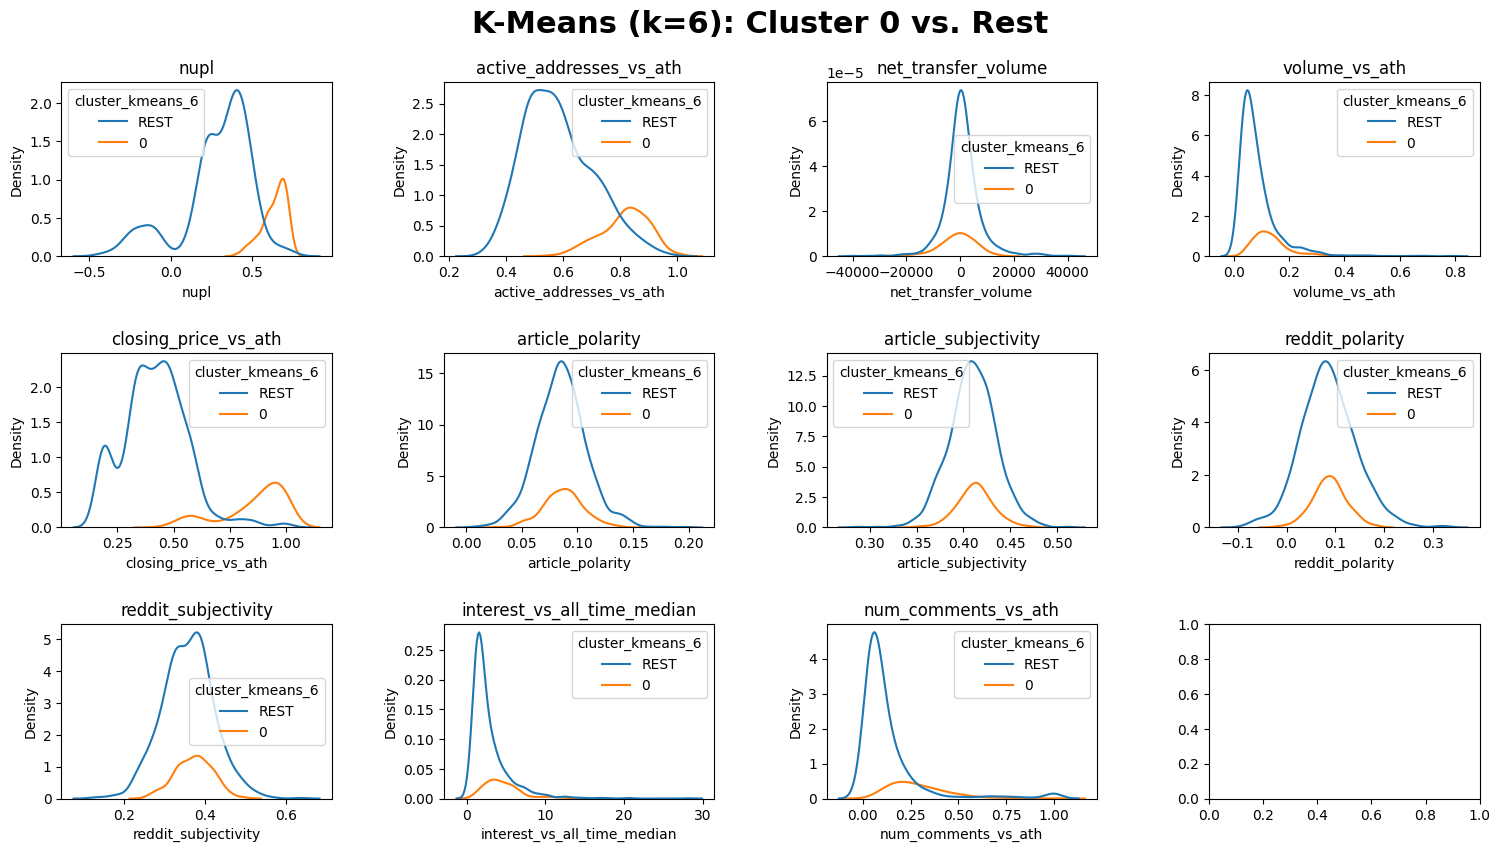

In [76]:
one_vs_rest_kde(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=0, viz_cols=4, title='K-Means (k=6): Cluster 0 vs. Rest')

In [77]:
one_vs_rest_table(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=0).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume             -1787.059287      -15.719508  -1004.757286   
interest_vs_all_time_median         1.634626       -0.270084      4.525660   
closing_price_vs_ath                0.439672        0.001489      0.857951   
nupl                                0.350879       -0.143482      0.635867   
active_addresses_vs_ath             0.233679       -0.037292      0.816335   
num_comments_vs_ath                 0.160140       -0.015329      0.289663   
volume_vs_ath                       0.043822       -0.017362      0.130025   
reddit_subjectivity                 0.014759       -0.019142      0.372386   
article_subjectivity                0.003087       -0.006073      0.412908   
reddit_polarity                     0.002042       -0.022075      0.087859   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          782.302000  6953.124924  6968.844433   
interest_vs_all_time_median    2.891034     2.275616     2.545700   
closing_price_vs_ath           0.418278     0.144212     0.142724   
nupl                           0.284988     0.073909     0.217391   
active_addresses_vs_ath        0.582656     0.084676     0.121967   
num_comments_vs_ath            0.129523     0.155045     0.170374   
volume_vs_ath                  0.086204     0.059218     0.076580   
reddit_subjectivity            0.357626     0.045356     0.064498   
article_subjectivity           0.409821     0.019216     0.025289   
reddit_polarity                0.085817     0.034593     0.056668   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -28398.132402  14877.497386 -39963.566228   
interest_vs_all_time_median      1.037037     13.085227      0.698448   
closing_price_vs_ath             0.473531      1.000000      0.161985   
nupl                             0.412283      0.746963     -0.431485   
active_addresses_vs_ath          0.549395      1.000000      0.315139   
num_comments_vs_ath              0.054493      1.000000      0.002868   
volume_vs_ath                    0.038065      0.338051      0.012939   
reddit_subjectivity              0.259857      0.490897      0.122346   
article_subjectivity             0.350475      0.471577      0.286019   
reddit_polarity                 -0.019639      0.182068     -0.090448   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
closing_price_vs_ath             1.000000  
nupl                             0.748802  
active_addresses_vs_ath          0.976224  
num_comments_vs_ath              1.000000  
volume_vs_ath                    0.787208  
reddit_subjectivity              0.635275  
article_subjectivity             0.510601  
reddit_polarity                  0.326905

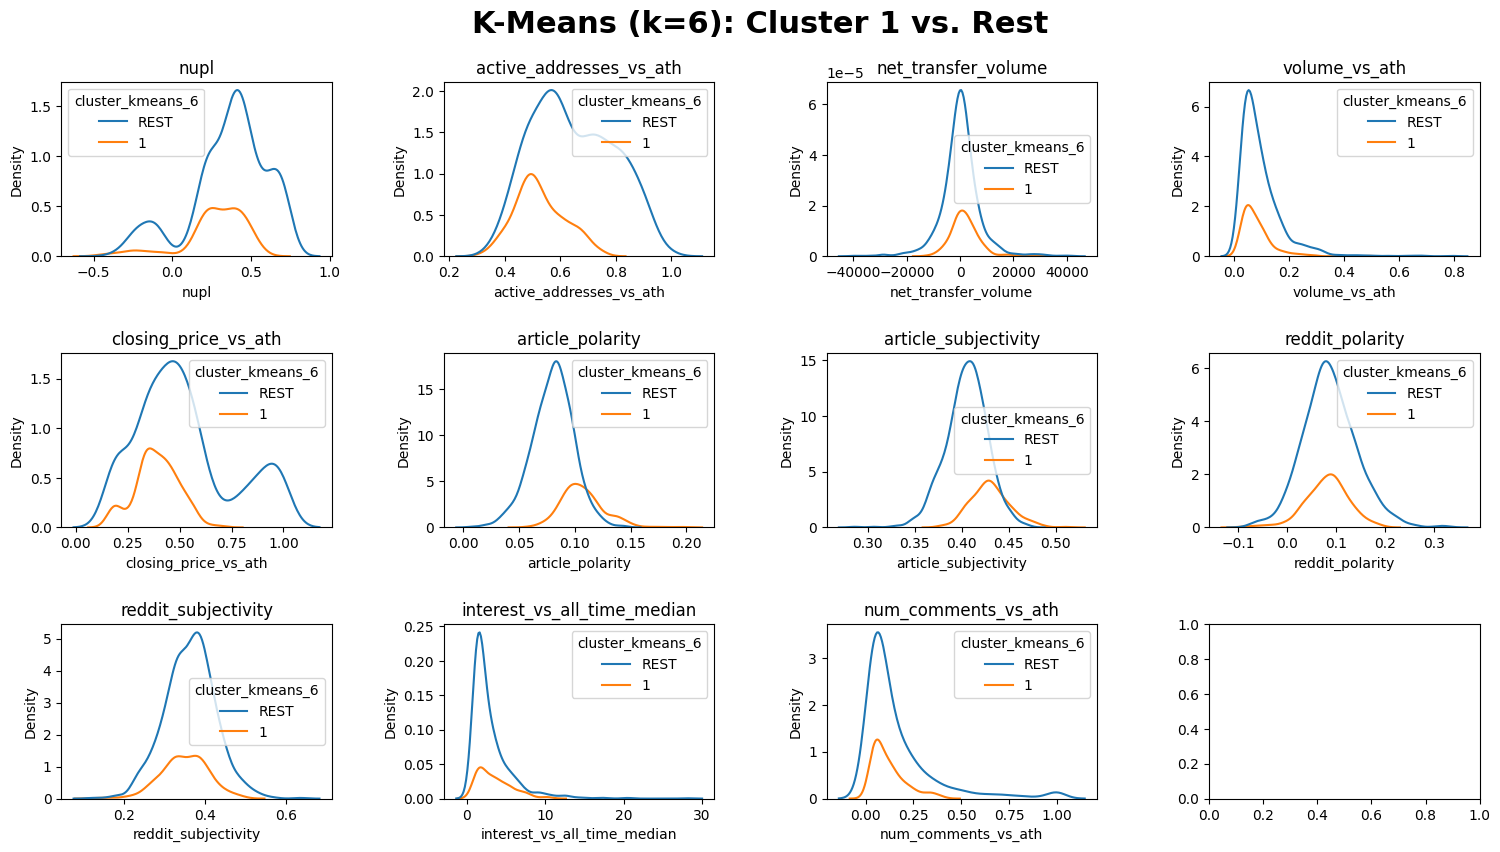

In [78]:
one_vs_rest_kde(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=1, viz_cols=4, title='K-Means (k=6): Cluster 1 vs. Rest')

In [79]:
one_vs_rest_table(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=1).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume              1655.834438    -1873.651343   1799.326914   
interest_vs_all_time_median         0.466361       -0.525238      3.532673   
closing_price_vs_ath               -0.128004       -0.126722      0.389752   
active_addresses_vs_ath            -0.119907       -0.057564      0.526331   
nupl                               -0.086027       -0.046530      0.275019   
num_comments_vs_ath                -0.045548       -0.107421      0.119986   
article_polarity                    0.026600        0.000300      0.106863   
article_subjectivity                0.025503       -0.001598      0.430572   
volume_vs_ath                      -0.015801       -0.023982      0.080946   
reddit_subjectivity                -0.012899       -0.005842      0.349843   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          143.492476  5436.774038  7310.425381   
interest_vs_all_time_median    3.066312     2.143222     2.668460   
closing_price_vs_ath           0.517756     0.104199     0.230920   
active_addresses_vs_ath        0.646238     0.089481     0.147045   
nupl                           0.361046     0.199386     0.245915   
num_comments_vs_ath            0.165533     0.086558     0.193979   
article_polarity               0.080263     0.019105     0.018804   
article_subjectivity           0.405068     0.020843     0.022441   
volume_vs_ath                  0.096747     0.055829     0.079810   
reddit_subjectivity            0.362742     0.057080     0.062921   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -12349.215388  29521.432923 -39963.566228   
interest_vs_all_time_median      0.986239     10.555556      0.698448   
closing_price_vs_ath             0.161985      0.700844      0.162631   
active_addresses_vs_ath          0.315139      0.746544      0.335241   
nupl                            -0.431485      0.549209     -0.401820   
num_comments_vs_ath              0.002868      0.407744      0.006692   
article_polarity                 0.059528      0.195214      0.007928   
article_subjectivity             0.378946      0.510601      0.286019   
volume_vs_ath                    0.012939      0.484370      0.014092   
reddit_subjectivity              0.134615      0.490463      0.122346   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
closing_price_vs_ath             1.000000  
active_addresses_vs_ath          1.000000  
nupl                             0.748802  
num_comments_vs_ath              1.000000  
article_polarity                 0.144828  
article_subjectivity             0.471577  
volume_vs_ath                    0.787208  
reddit_subjectivity              0.635275

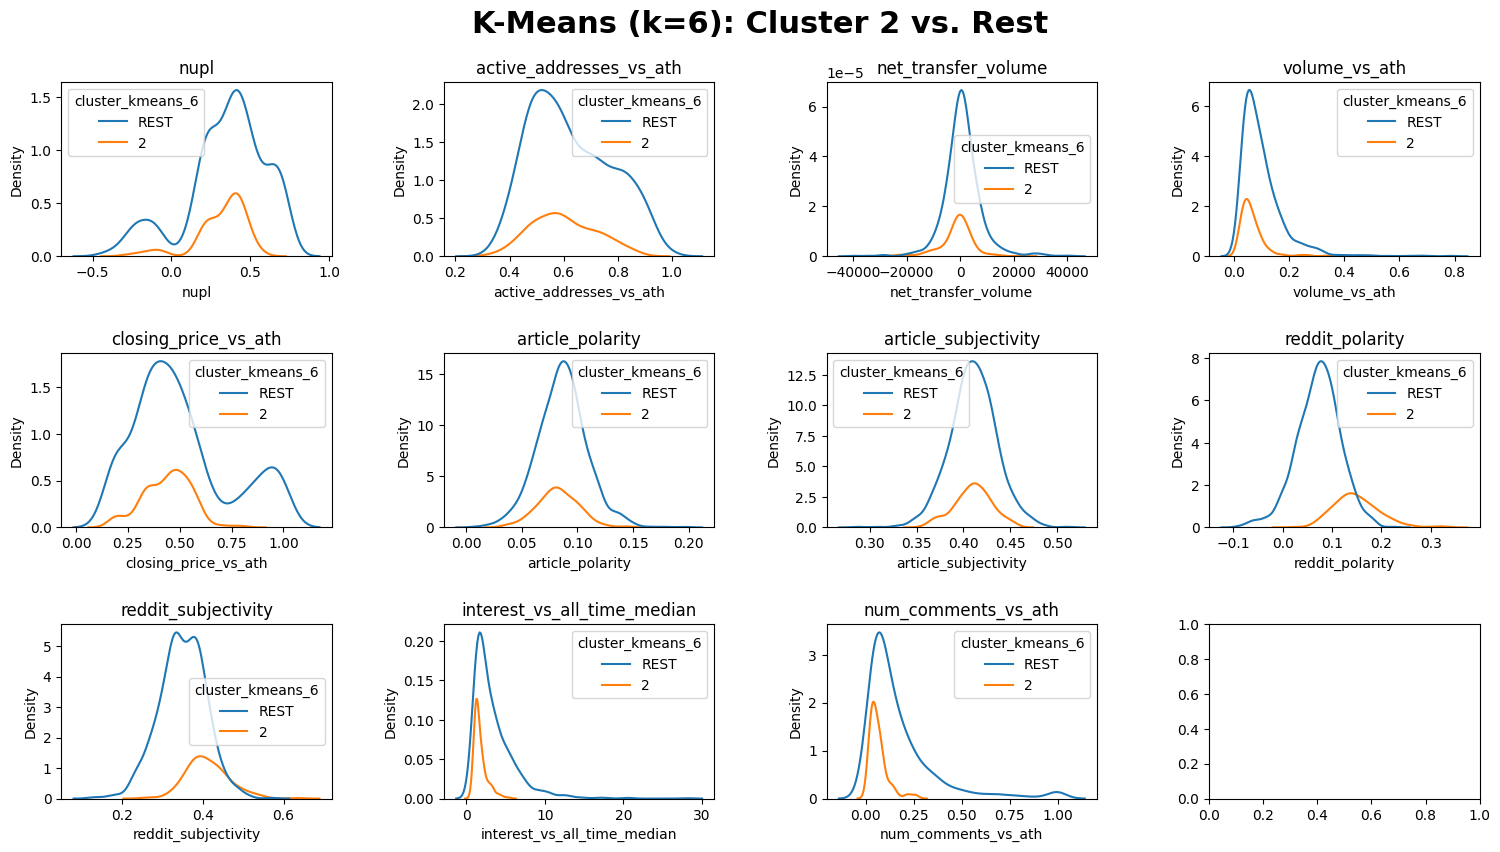

In [80]:
one_vs_rest_kde(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=2, viz_cols=4, title='K-Means (k=6): Cluster 2 vs. Rest')

In [81]:
one_vs_rest_table(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=2).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume             -2128.631957     -783.497379  -1264.320669   
interest_vs_all_time_median        -1.692936       -1.894928      1.771026   
num_comments_vs_ath                -0.108893       -0.140716      0.066619   
reddit_polarity                     0.076808        0.001647      0.149292   
closing_price_vs_ath               -0.062670       -0.118033      0.439811   
reddit_subjectivity                 0.062040       -0.005075      0.411075   
volume_vs_ath                      -0.035682       -0.035236      0.064154   
nupl                               -0.029221       -0.091451      0.319263   
active_addresses_vs_ath            -0.026480       -0.032567      0.599713   
article_polarity                   -0.003917       -0.003760      0.082536   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          864.311289  6299.490135  7082.987514   
interest_vs_all_time_median    3.463963     0.827091     2.722019   
num_comments_vs_ath            0.175512     0.048976     0.189692   
reddit_polarity                0.072484     0.046224     0.044577   
closing_price_vs_ath           0.502481     0.114233     0.232267   
reddit_subjectivity            0.349035     0.053046     0.058121   
volume_vs_ath                  0.099836     0.044317     0.079552   
nupl                           0.348484     0.161581     0.253032   
active_addresses_vs_ath        0.626193     0.117848     0.150415   
article_polarity               0.086453     0.018535     0.022295   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -29400.328279  21996.994858 -39963.566228   
interest_vs_all_time_median      0.698448      5.462766      0.750000   
num_comments_vs_ath              0.008126      0.269598      0.002868   
reddit_polarity                  0.026429      0.326905     -0.090448   
closing_price_vs_ath             0.174936      0.799276      0.161985   
reddit_subjectivity              0.256448      0.635275      0.122346   
volume_vs_ath                    0.014274      0.330227      0.012939   
nupl                            -0.282298      0.560104     -0.431485   
active_addresses_vs_ath          0.335241      0.871492      0.315139   
article_polarity                 0.035477      0.144828      0.007928   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
num_comments_vs_ath              1.000000  
reddit_polarity                  0.223760  
closing_price_vs_ath             1.000000  
reddit_subjectivity              0.570603  
volume_vs_ath                    0.787208  
nupl                             0.748802  
active_addresses_vs_ath          1.000000  
article_polarity                 0.195214

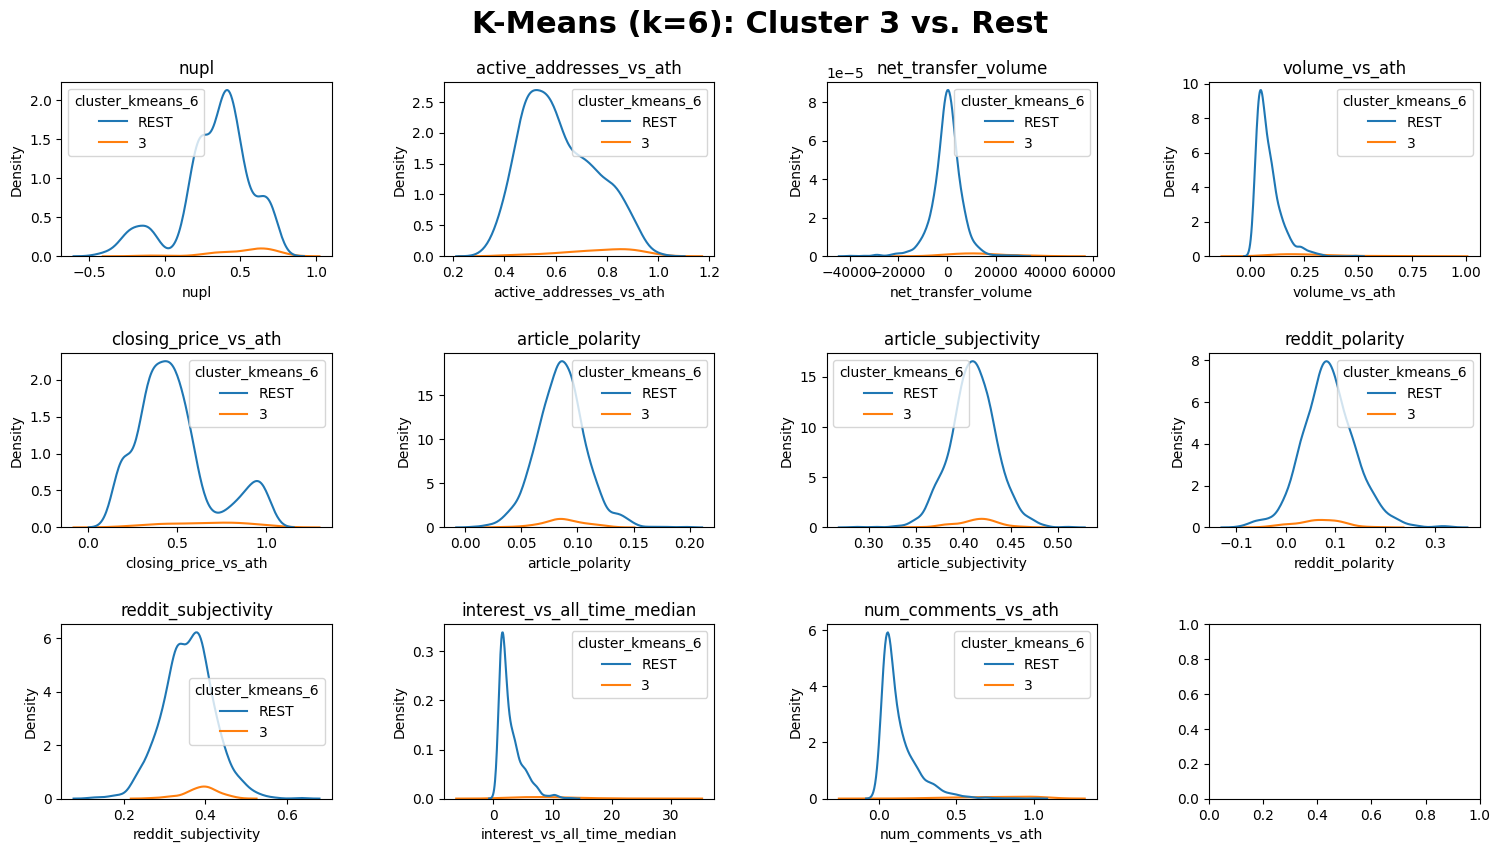

In [82]:
one_vs_rest_kde(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=3, viz_cols=4, title='K-Means (k=6): Cluster 3 vs. Rest')

In [83]:
one_vs_rest_table(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=3).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume             13066.267737     5140.247871  12983.121023   
interest_vs_all_time_median         6.300586        3.444873      9.189040   
num_comments_vs_ath                 0.614192        0.125802      0.743596   
volume_vs_ath                       0.189944        0.105154      0.275163   
nupl                                0.182962       -0.034796      0.518283   
closing_price_vs_ath                0.168858        0.008512      0.652835   
active_addresses_vs_ath             0.145763        0.002835      0.760899   
reddit_subjectivity                 0.032078       -0.022363      0.390760   
reddit_polarity                    -0.020883       -0.009378      0.066182   
article_subjectivity                0.003503       -0.003025      0.413685   

                             Rest Mean   Cluster STD     Rest STD  \
net_transfer_volume         -83.146715  11305.647828  6165.399957   
interest_vs_all_time_median   2.888454      5.417573     1.972700   
num_comments_vs_ath           0.129403      0.244461     0.118659   
volume_vs_ath                 0.085219      0.162166     0.057012   
nupl                          0.335321      0.203283     0.238080   
closing_price_vs_ath          0.483978      0.222793     0.214281   
active_addresses_vs_ath       0.615136      0.145160     0.142324   
reddit_subjectivity           0.358683      0.040064     0.062427   
reddit_polarity               0.087065      0.044469     0.053847   
article_subjectivity          0.410182      0.021501     0.024526   

                             Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -9491.332057  41204.164457 -39963.566228   
interest_vs_all_time_median     0.990000     28.000000      0.698448   
num_comments_vs_ath             0.070268      1.000000      0.002868   
volume_vs_ath                   0.085200      0.787208      0.012939   
nupl                           -0.137618      0.748802     -0.431485   
closing_price_vs_ath            0.221335      1.000000      0.161985   
active_addresses_vs_ath         0.416616      0.976224      0.315139   
reddit_subjectivity             0.271461      0.472237      0.122346   
reddit_polarity                -0.032770      0.177257     -0.090448   
article_subjectivity            0.349301      0.461164      0.286019   

                                 Rest Max  
net_transfer_volume          29521.432923  
interest_vs_all_time_median     13.085227  
num_comments_vs_ath              1.000000  
volume_vs_ath                    0.484370  
nupl                             0.746963  
closing_price_vs_ath             1.000000  
active_addresses_vs_ath          1.000000  
reddit_subjectivity              0.635275  
reddit_polarity                  0.326905  
article_subjectivity             0.510601

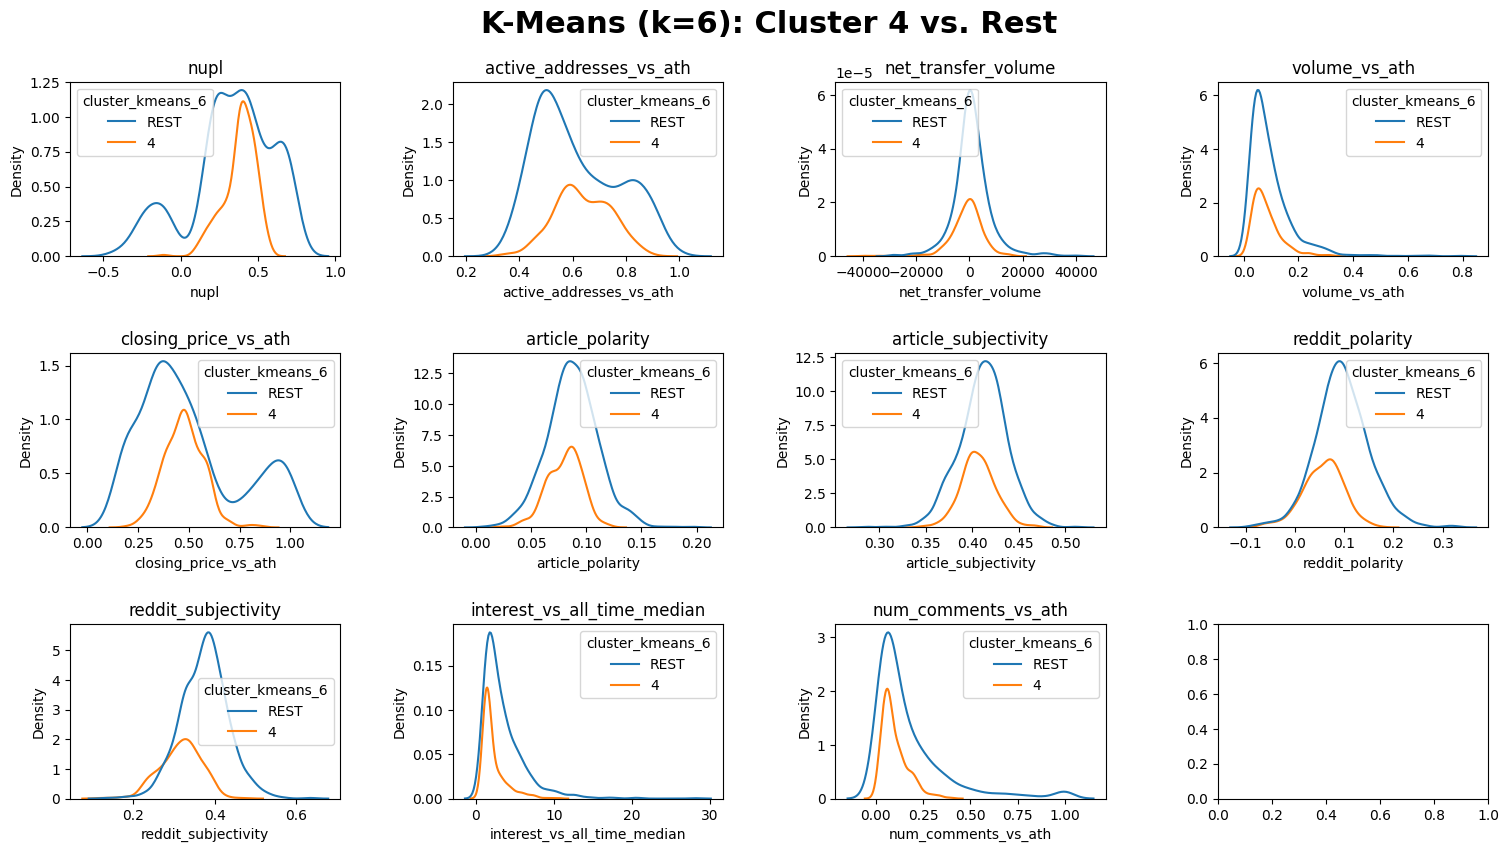

In [84]:
one_vs_rest_kde(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=4, viz_cols=4, title='K-Means (k=6): Cluster 4 vs. Rest')

In [85]:
one_vs_rest_table(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=4).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume             -1907.053432     -999.950474   -937.345022   
interest_vs_all_time_median        -1.275223       -1.235910      2.211236   
num_comments_vs_ath                -0.075085       -0.130833      0.100112   
reddit_subjectivity                -0.058390       -0.007673      0.316517   
nupl                                0.050515       -0.164289      0.380968   
reddit_polarity                    -0.038595       -0.012728      0.057363   
active_addresses_vs_ath             0.022099       -0.052679      0.637966   
closing_price_vs_ath               -0.020267       -0.149214      0.476205   
volume_vs_ath                      -0.013361       -0.029982      0.083516   
article_polarity                   -0.007104       -0.007552      0.080456   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          969.708410  6188.463242  7188.413716   
interest_vs_all_time_median    3.486459     1.534708     2.770618   
num_comments_vs_ath            0.175197     0.068023     0.198856   
reddit_subjectivity            0.374907     0.050698     0.058371   
nupl                           0.330454     0.105025     0.269314   
reddit_polarity                0.095958     0.041144     0.053872   
active_addresses_vs_ath        0.615867     0.104062     0.156741   
closing_price_vs_ath           0.496472     0.095919     0.245133   
volume_vs_ath                  0.096877     0.052028     0.082010   
article_polarity               0.087560     0.015616     0.023168   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -39963.566228  15414.516038 -29400.328279   
interest_vs_all_time_median      0.750000     10.372881      0.698448   
num_comments_vs_ath              0.006692      0.395315      0.002868   
reddit_subjectivity              0.122346      0.471259      0.134615   
nupl                            -0.111220      0.574878     -0.431485   
reddit_polarity                 -0.069953      0.171167     -0.090448   
active_addresses_vs_ath          0.344613      0.894218      0.315139   
closing_price_vs_ath             0.200457      0.851228      0.161985   
volume_vs_ath                    0.016765      0.320306      0.012939   
article_polarity                 0.023756      0.121301      0.007928   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
num_comments_vs_ath              1.000000  
reddit_subjectivity              0.635275  
nupl                             0.748802  
reddit_polarity                  0.326905  
active_addresses_vs_ath          1.000000  
closing_price_vs_ath             1.000000  
volume_vs_ath                    0.787208  
article_polarity                 0.195214

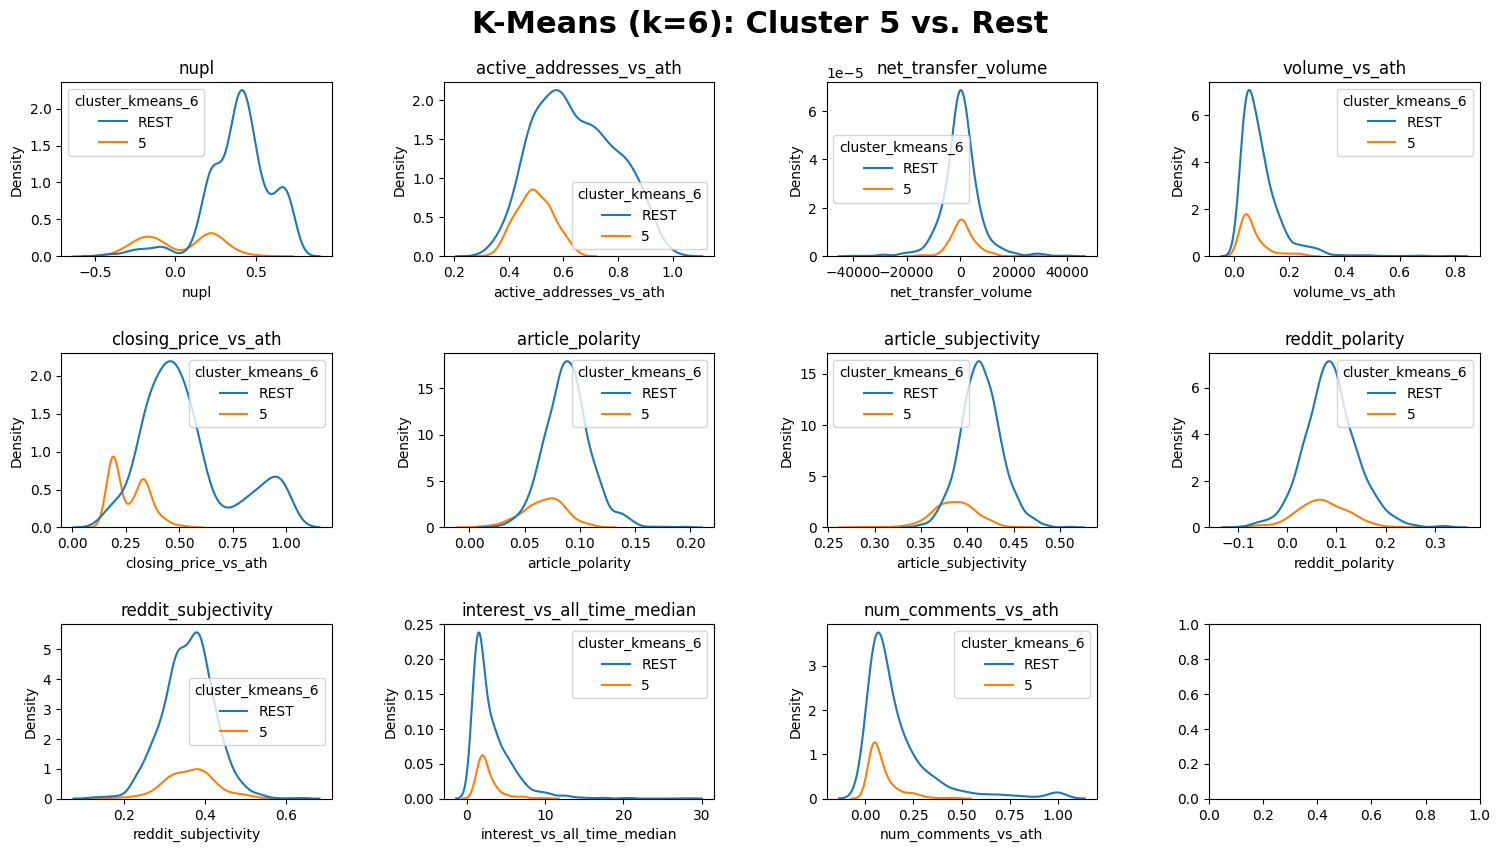

In [86]:
one_vs_rest_kde(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=5, viz_cols=4, title='K-Means (k=6): Cluster 5 vs. Rest')

In [87]:
one_vs_rest_table(kmeans_6_data.copy(), cluster_col='cluster_kmeans_6', cluster_val=5).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume               816.856409    -2143.044055   1178.178283   
interest_vs_all_time_median        -0.588226       -1.255295      2.663734   
nupl                               -0.368125        0.023321      0.031075   
closing_price_vs_ath               -0.263577       -0.126689      0.267785   
active_addresses_vs_ath            -0.148304       -0.079979      0.495702   
num_comments_vs_ath                -0.078600       -0.111186      0.089468   
article_subjectivity               -0.029052        0.001663      0.385696   
volume_vs_ath                      -0.028215       -0.027269      0.069555   
article_polarity                   -0.021416       -0.001622      0.067593   
reddit_polarity                    -0.017938       -0.002549      0.070943   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          361.321873  5130.810193  7273.854249   
interest_vs_all_time_median    3.251960     1.462269     2.717564   
nupl                           0.399200     0.219453     0.196132   
closing_price_vs_ath           0.531362     0.082849     0.209538   
active_addresses_vs_ath        0.644006     0.064478     0.144457   
num_comments_vs_ath            0.168068     0.077033     0.188218   
article_subjectivity           0.414747     0.023476     0.021813   
volume_vs_ath                  0.097770     0.051305     0.078573   
article_polarity               0.089009     0.018935     0.020557   
reddit_polarity                0.088881     0.051090     0.053639   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -15599.786568  25533.949058 -39963.566228   
interest_vs_all_time_median      1.052782     10.230769      0.698448   
nupl                            -0.401820      0.499568     -0.431485   
closing_price_vs_ath             0.162631      0.525363      0.161985   
active_addresses_vs_ath          0.339582      0.652266      0.315139   
num_comments_vs_ath              0.010038      0.467973      0.002868   
article_subjectivity             0.286019      0.452302      0.345982   
volume_vs_ath                    0.014092      0.256356      0.012939   
article_polarity                 0.007928      0.112581      0.023756   
reddit_polarity                 -0.080692      0.223760     -0.090448   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
nupl                             0.748802  
closing_price_vs_ath             1.000000  
active_addresses_vs_ath          1.000000  
num_comments_vs_ath              1.000000  
article_subjectivity             0.510601  
volume_vs_ath                    0.787208  
article_polarity                 0.195214  
reddit_polarity                  0.326905

## One vs. Rest Plots - Gaussian Mixture - 6 Clusters

In [88]:
# Drop irrelevant columns
gaussian_6_data = sentiment_cluster_data.drop(columns=['cluster_kmeans_9', 'cluster_hdbscan', 'cluster_dbscan', 'cluster_kmeans_6', 'cluster_hac'])

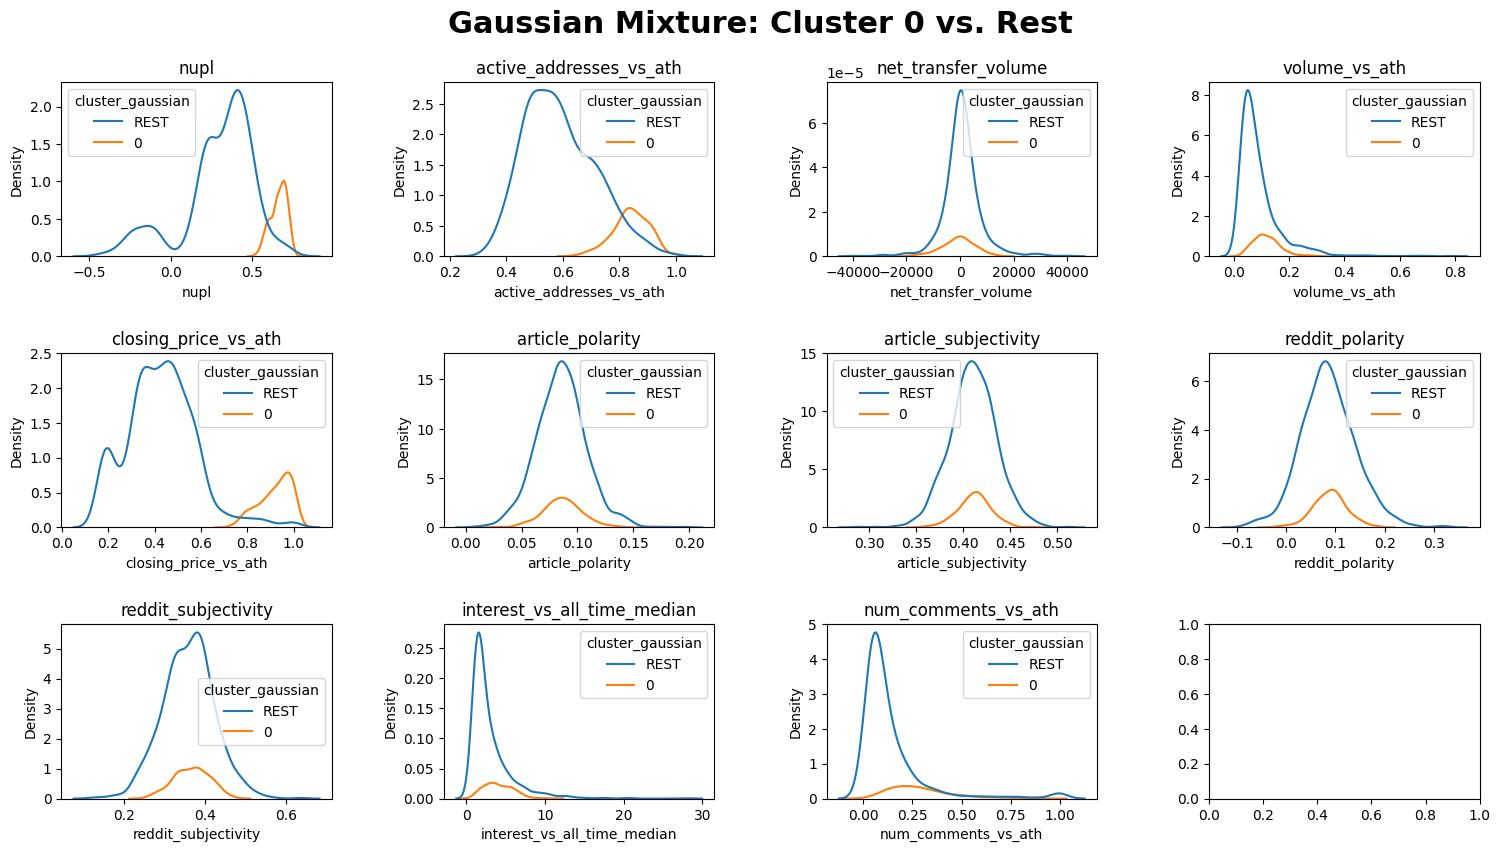

In [89]:
one_vs_rest_kde(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=0, viz_cols=4, title='Gaussian Mixture: Cluster 0 vs. Rest')

In [90]:
one_vs_rest_table(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=0).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume             -1314.992917    -1117.611468   -661.056105   
interest_vs_all_time_median         1.095479       -0.855661      4.117687   
closing_price_vs_ath                0.491905       -0.081572      0.920186   
nupl                                0.364781       -0.170626      0.661311   
active_addresses_vs_ath             0.251985       -0.060990      0.841168   
num_comments_vs_ath                 0.152027       -0.016482      0.288671   
volume_vs_ath                       0.027420       -0.031773      0.117390   
reddit_subjectivity                 0.007896       -0.020760      0.366962   
reddit_polarity                     0.002983       -0.021560      0.088757   
article_subjectivity                0.001805       -0.007535      0.411908   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          653.936812  5999.144432  7116.755900   
interest_vs_all_time_median    3.022208     1.787253     2.642913   
closing_price_vs_ath           0.428280     0.068273     0.149846   
nupl                           0.296530     0.049353     0.219979   
active_addresses_vs_ath        0.589183     0.063652     0.124642   
num_comments_vs_ath            0.136644     0.156333     0.172816   
volume_vs_ath                  0.089970     0.046739     0.078511   
reddit_subjectivity            0.359067     0.043427     0.064187   
reddit_polarity                0.085774     0.034346     0.055906   
article_subjectivity           0.410103     0.017704     0.025239   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -16785.871930  13487.625553 -39963.566228   
interest_vs_all_time_median      1.037037     10.416667      0.698448   
closing_price_vs_ath             0.735600      1.000000      0.161985   
nupl                             0.526589      0.746963     -0.431485   
active_addresses_vs_ath          0.650595      1.000000      0.315139   
num_comments_vs_ath              0.070268      0.866219      0.002868   
volume_vs_ath                    0.037755      0.289557      0.012939   
reddit_subjectivity              0.259857      0.464388      0.122346   
reddit_polarity                 -0.019639      0.182068     -0.090448   
article_subjectivity             0.359115      0.471577      0.286019   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
closing_price_vs_ath             1.000000  
nupl                             0.748802  
active_addresses_vs_ath          1.000000  
num_comments_vs_ath              1.000000  
volume_vs_ath                    0.787208  
reddit_subjectivity              0.635275  
reddit_polarity                  0.326905  
article_subjectivity             0.510601

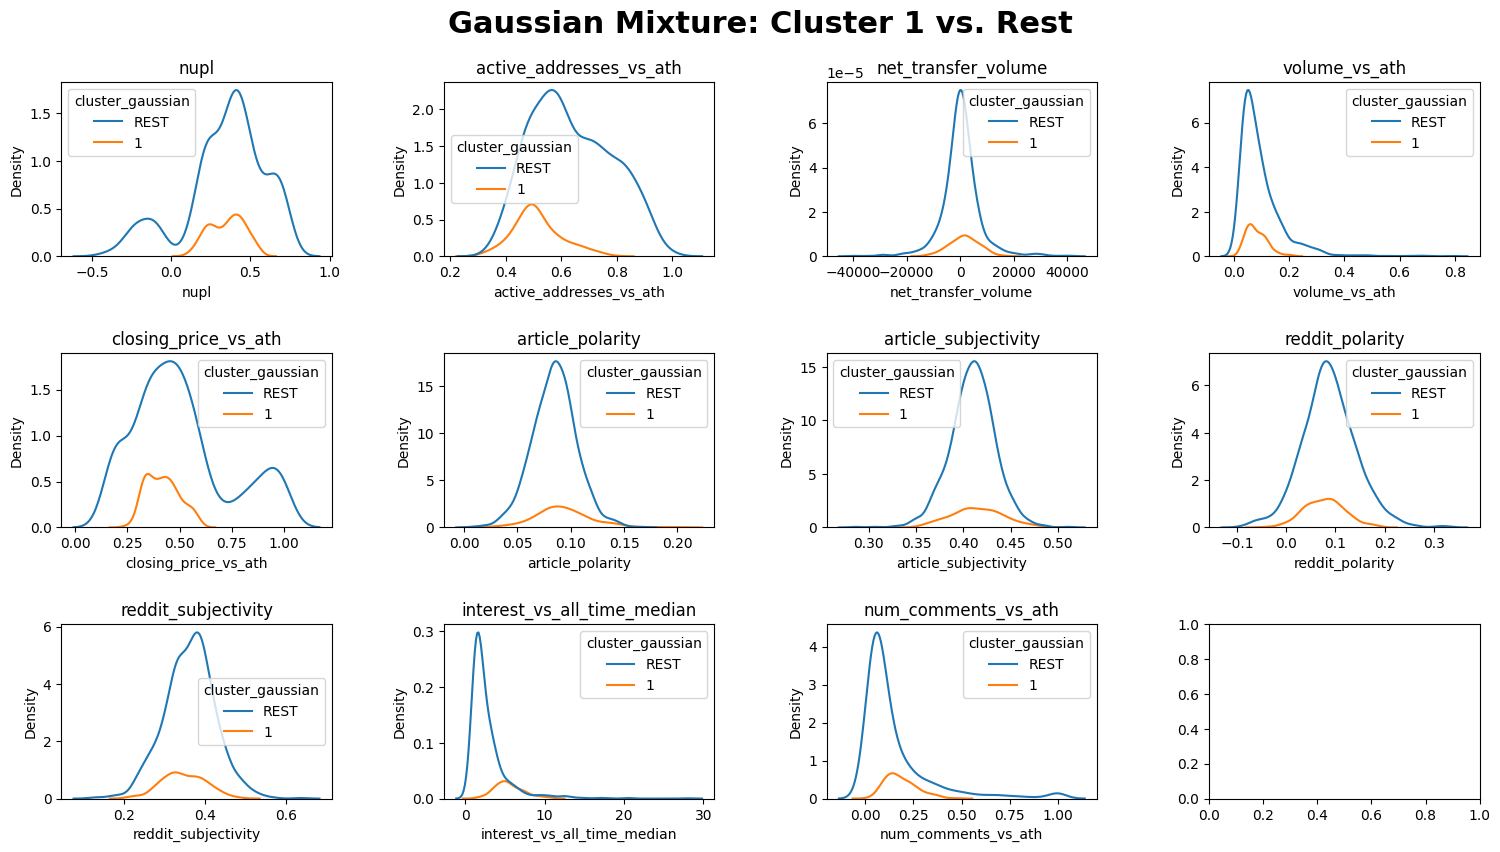

In [91]:
one_vs_rest_kde(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=1, viz_cols=4, title='Gaussian Mixture: Cluster 1 vs. Rest')

In [92]:
one_vs_rest_table(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=1).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume              1202.309193    -1717.173689   1528.861126   
interest_vs_all_time_median         2.704407       -0.674185      5.509709   
active_addresses_vs_ath            -0.124127       -0.058993      0.513751   
closing_price_vs_ath               -0.083032       -0.151432      0.419264   
num_comments_vs_ath                 0.032474       -0.106750      0.184312   
reddit_subjectivity                -0.014988       -0.010411      0.347071   
volume_vs_ath                      -0.014700       -0.042571      0.080727   
reddit_polarity                    -0.009820       -0.014845      0.077634   
article_polarity                    0.008044        0.005218      0.092737   
nupl                                0.007820       -0.145599      0.350069   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          326.551933  5470.653822  7187.827511   
interest_vs_all_time_median    2.805302     1.811120     2.485305   
active_addresses_vs_ath        0.637879     0.086642     0.145635   
closing_price_vs_ath           0.502295     0.077897     0.229329   
num_comments_vs_ath            0.151838     0.081466     0.188216   
reddit_subjectivity            0.362059     0.052633     0.063044   
volume_vs_ath                  0.095426     0.037249     0.079820   
reddit_polarity                0.087454     0.040418     0.055263   
article_polarity               0.084693     0.026015     0.020797   
nupl                           0.342249     0.108056     0.253654   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -12349.215388  16341.778060 -39963.566228   
interest_vs_all_time_median      1.652324     10.555556      0.698448   
active_addresses_vs_ath          0.315139      0.767292      0.335241   
closing_price_vs_ath             0.249694      0.587073      0.161985   
num_comments_vs_ath              0.022467      0.467973      0.002868   
reddit_subjectivity              0.221597      0.477435      0.122346   
volume_vs_ath                    0.016765      0.206215      0.012939   
reddit_polarity                 -0.038062      0.181008     -0.090448   
article_polarity                 0.023756      0.195214      0.007928   
nupl                             0.124273      0.544585     -0.431485   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
active_addresses_vs_ath          1.000000  
closing_price_vs_ath             1.000000  
num_comments_vs_ath              1.000000  
reddit_subjectivity              0.635275  
volume_vs_ath                    0.787208  
reddit_polarity                  0.326905  
article_polarity                 0.165295  
nupl                             0.748802

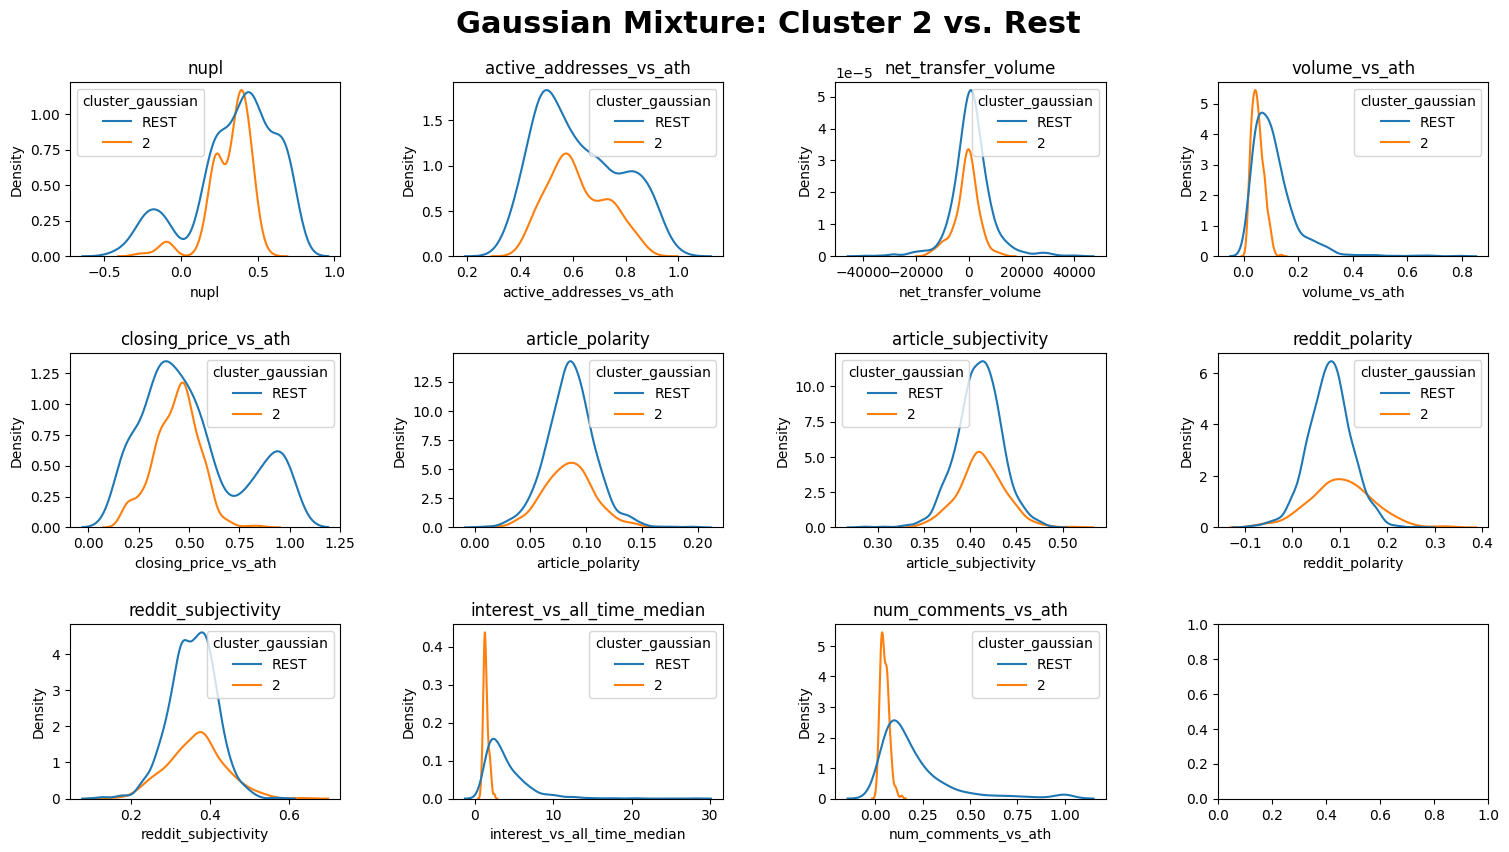

In [93]:
one_vs_rest_kde(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=2, viz_cols=4, title='Gaussian Mixture: Cluster 2 vs. Rest')

In [94]:
one_vs_rest_table(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=2).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume             -1913.156078    -3135.392485   -840.488485   
interest_vs_all_time_median        -2.553982       -2.418728      1.392602   
num_comments_vs_ath                -0.153849       -0.173247      0.049505   
closing_price_vs_ath               -0.076916       -0.136245      0.438020   
volume_vs_ath                      -0.060404       -0.061587      0.051622   
nupl                               -0.033269       -0.132260      0.320225   
reddit_polarity                     0.023782        0.020174      0.102638   
reddit_subjectivity                 0.007788        0.013690      0.365476   
active_addresses_vs_ath            -0.004511       -0.046776      0.618352   
article_subjectivity                0.002918        0.000767      0.412356   

                               Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          1072.667592  4615.911632  7751.304117   
interest_vs_all_time_median     3.946585     0.323486     2.742214   
num_comments_vs_ath             0.203354     0.022480     0.195727   
closing_price_vs_ath            0.514935     0.110612     0.246858   
volume_vs_ath                   0.112026     0.021771     0.083358   
nupl                            0.353495     0.139523     0.271784   
reddit_polarity                 0.078856     0.065671     0.045497   
reddit_subjectivity             0.357688     0.071048     0.057358   
active_addresses_vs_ath         0.622864     0.111468     0.158244   
article_subjectivity            0.409439     0.024907     0.024140   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -15850.965418  13443.914807 -39963.566228   
interest_vs_all_time_median      0.698448      2.526087      0.850549   
num_comments_vs_ath              0.002868      0.139579      0.005258   
closing_price_vs_ath             0.174936      0.851228      0.161985   
volume_vs_ath                    0.012939      0.137483      0.015860   
nupl                            -0.282298      0.565391     -0.431485   
reddit_polarity                 -0.071107      0.326905     -0.090448   
reddit_subjectivity              0.155904      0.635275      0.122346   
active_addresses_vs_ath          0.395361      0.894218      0.315139   
article_subjectivity             0.345982      0.510601      0.286019   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
num_comments_vs_ath              1.000000  
closing_price_vs_ath             1.000000  
volume_vs_ath                    0.787208  
nupl                             0.748802  
reddit_polarity                  0.264403  
reddit_subjectivity              0.570603  
active_addresses_vs_ath          1.000000  
article_subjectivity             0.485680

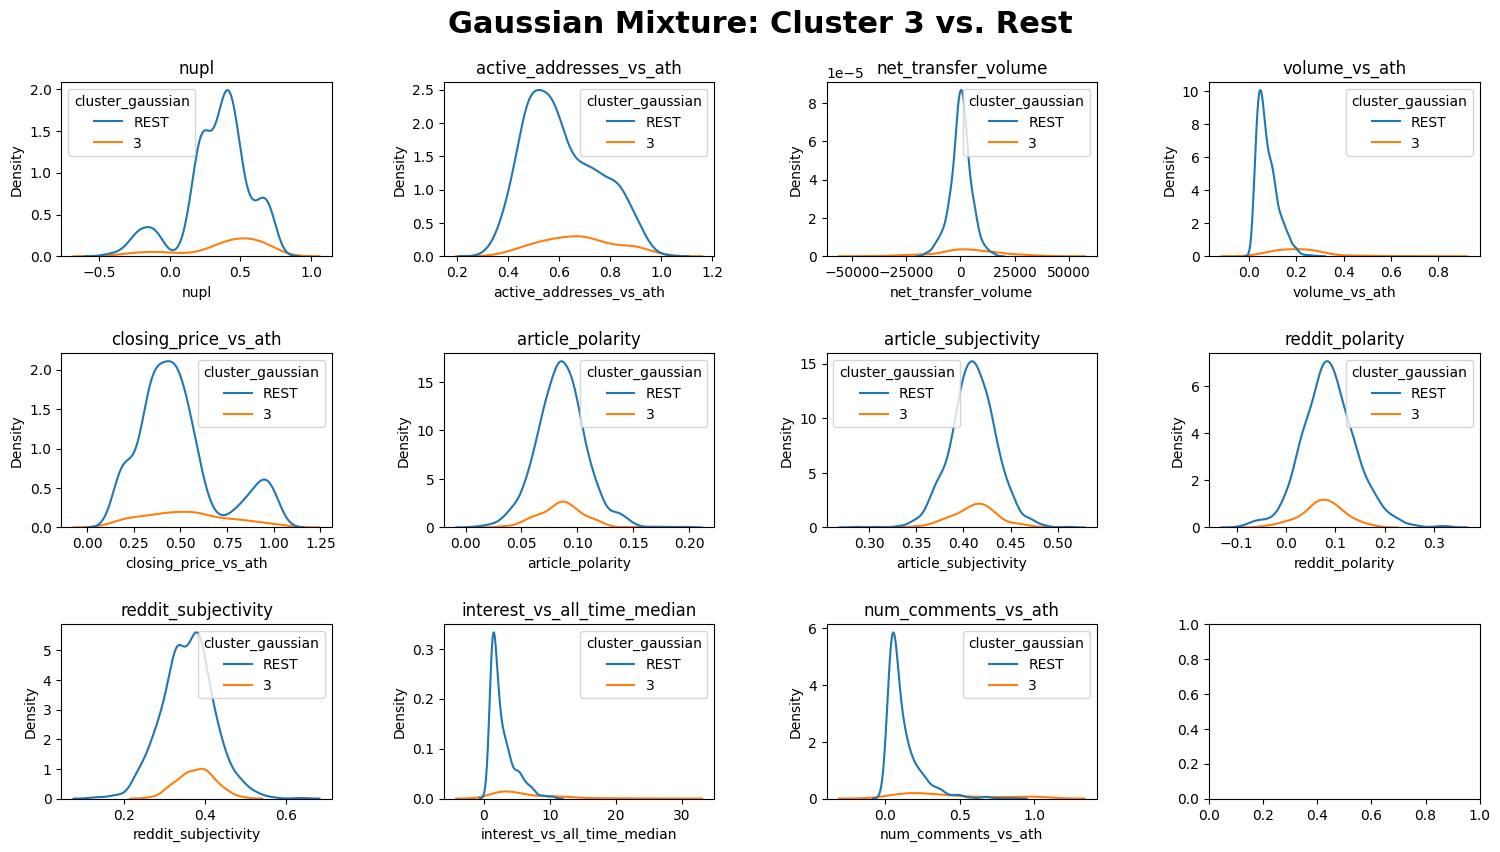

In [95]:
one_vs_rest_kde(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=3, viz_cols=4, title='Gaussian Mixture: Cluster 3 vs. Rest')

In [96]:
one_vs_rest_table(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=3).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume              2958.803461     9908.418104   3081.376833   
interest_vs_all_time_median         3.263843        2.763267      6.026218   
num_comments_vs_ath                 0.288456        0.197405      0.409212   
volume_vs_ath                       0.142181        0.082509      0.218230   
active_addresses_vs_ath             0.061871        0.003140      0.675763   
nupl                                0.048533        0.051596      0.385864   
closing_price_vs_ath                0.047305        0.008463      0.532829   
reddit_subjectivity                 0.021247       -0.018991      0.378720   
reddit_polarity                    -0.012594       -0.011768      0.075107   
article_subjectivity                0.001822       -0.000183      0.411933   

                              Rest Mean   Cluster STD     Rest STD  \
net_transfer_volume          122.573372  14823.839182  4915.421078   
interest_vs_all_time_median    2.762375      4.587018     1.823752   
num_comments_vs_ath            0.120756      0.309765     0.112360   
volume_vs_ath                  0.076049      0.125664     0.043155   
active_addresses_vs_ath        0.613892      0.146851     0.143711   
nupl                           0.337331      0.283797     0.232202   
closing_price_vs_ath           0.485524      0.224260     0.215797   
reddit_subjectivity            0.357473      0.044601     0.063593   
reddit_polarity                0.087701      0.043019     0.054787   
article_subjectivity           0.410111      0.024247     0.024430   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -39963.566228  41204.164457 -16785.871930   
interest_vs_all_time_median      0.850549     28.000000      0.698448   
num_comments_vs_ath              0.029159      1.000000      0.002868   
volume_vs_ath                    0.019401      0.787208      0.012939   
active_addresses_vs_ath          0.358849      1.000000      0.315139   
nupl                            -0.371567      0.748802     -0.431485   
closing_price_vs_ath             0.172011      1.000000      0.161985   
reddit_subjectivity              0.264298      0.492236      0.122346   
reddit_polarity                 -0.045692      0.177257     -0.090448   
article_subjectivity             0.326139      0.476598      0.286019   

                                 Rest Max  
net_transfer_volume          16341.778060  
interest_vs_all_time_median     10.555556  
num_comments_vs_ath              0.866219  
volume_vs_ath                    0.289557  
active_addresses_vs_ath          1.000000  
nupl                             0.746963  
closing_price_vs_ath             1.000000  
reddit_subjectivity              0.635275  
reddit_polarity                  0.326905  
article_subjectivity             0.510601

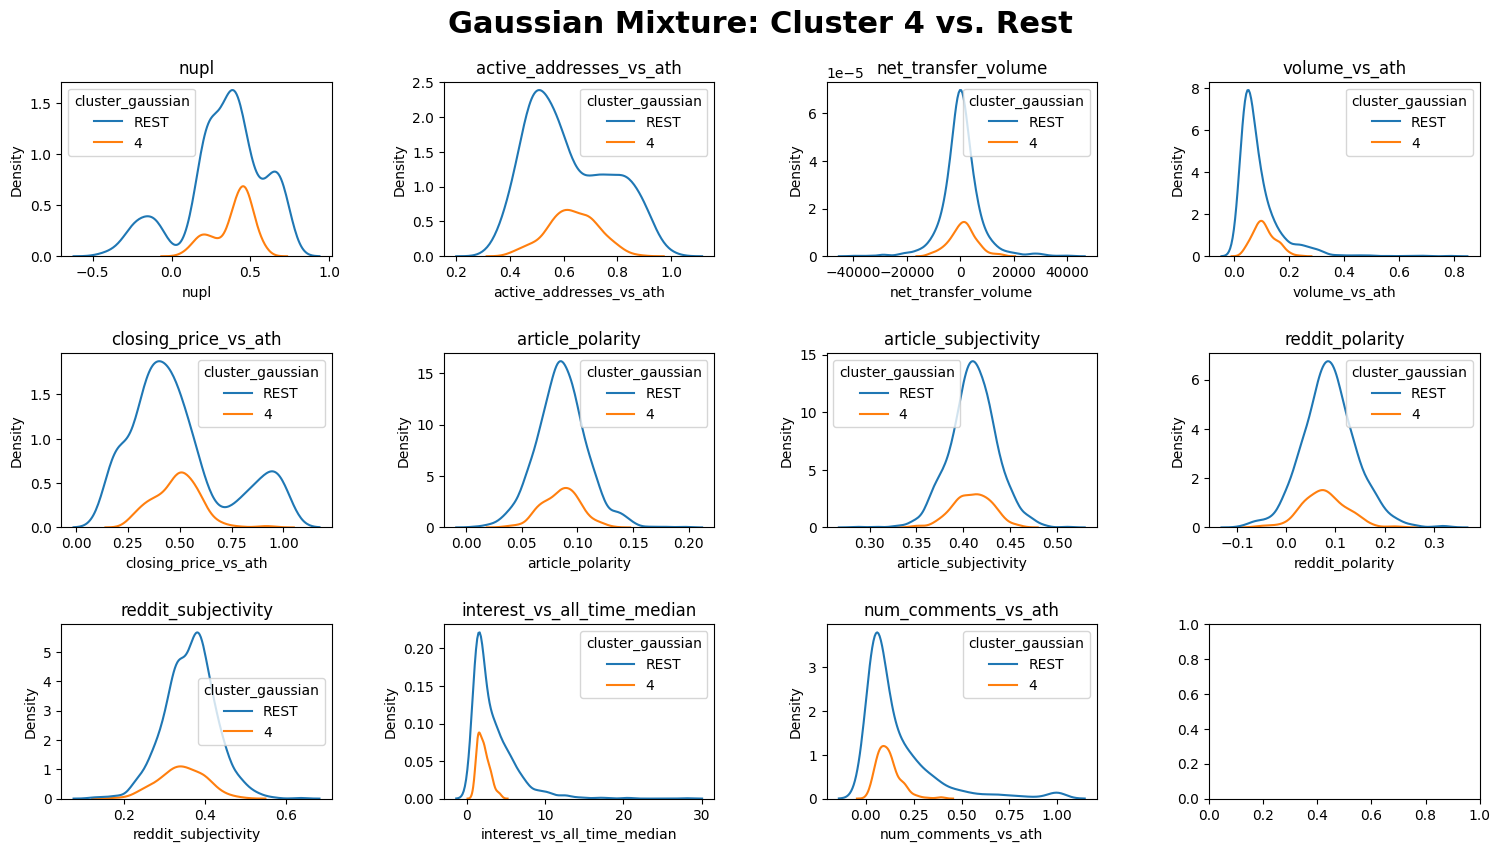

In [97]:
one_vs_rest_kde(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=4, viz_cols=4, title='Gaussian Mixture: Cluster 4 vs. Rest')

In [98]:
one_vs_rest_table(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=4).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume               678.994052    -2321.937852   1052.125002   
interest_vs_all_time_median        -1.242946       -2.001087      2.125182   
nupl                                0.059880       -0.133417      0.393261   
num_comments_vs_ath                -0.046672       -0.131368      0.117174   
reddit_subjectivity                -0.020902       -0.006341      0.342633   
volume_vs_ath                       0.018200       -0.040283      0.108675   
active_addresses_vs_ath             0.013618       -0.062024      0.632845   
reddit_polarity                    -0.010592       -0.010548      0.077316   
closing_price_vs_ath               -0.007496       -0.121719      0.485068   
article_subjectivity               -0.000806       -0.004842      0.409662   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          373.130951  5000.918060  7322.855912   
interest_vs_all_time_median    3.368128     0.751729     2.752816   
nupl                           0.333381     0.121970     0.255387   
num_comments_vs_ath            0.163845     0.060822     0.192189   
reddit_subjectivity            0.363535     0.056154     0.062495   
volume_vs_ath                  0.090475     0.040324     0.080608   
active_addresses_vs_ath        0.619227     0.091801     0.153825   
reddit_polarity                0.087908     0.044551     0.055100   
closing_price_vs_ath           0.492565     0.110985     0.232704   
article_subjectivity           0.410468     0.020303     0.025145   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -11203.864118  15414.516038 -39963.566228   
interest_vs_all_time_median      0.870000      4.428571      0.698448   
nupl                             0.061036      0.607835     -0.431485   
num_comments_vs_ath              0.016730      0.393282      0.002868   
reddit_subjectivity              0.179621      0.490777      0.122346   
volume_vs_ath                    0.031066      0.238292      0.012939   
active_addresses_vs_ath          0.408183      0.877451      0.315139   
reddit_polarity                 -0.055468      0.220770     -0.090448   
closing_price_vs_ath             0.256522      0.935614      0.161985   
article_subjectivity             0.350475      0.458274      0.286019   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
nupl                             0.748802  
num_comments_vs_ath              1.000000  
reddit_subjectivity              0.635275  
volume_vs_ath                    0.787208  
active_addresses_vs_ath          1.000000  
reddit_polarity                  0.326905  
closing_price_vs_ath             1.000000  
article_subjectivity             0.510601

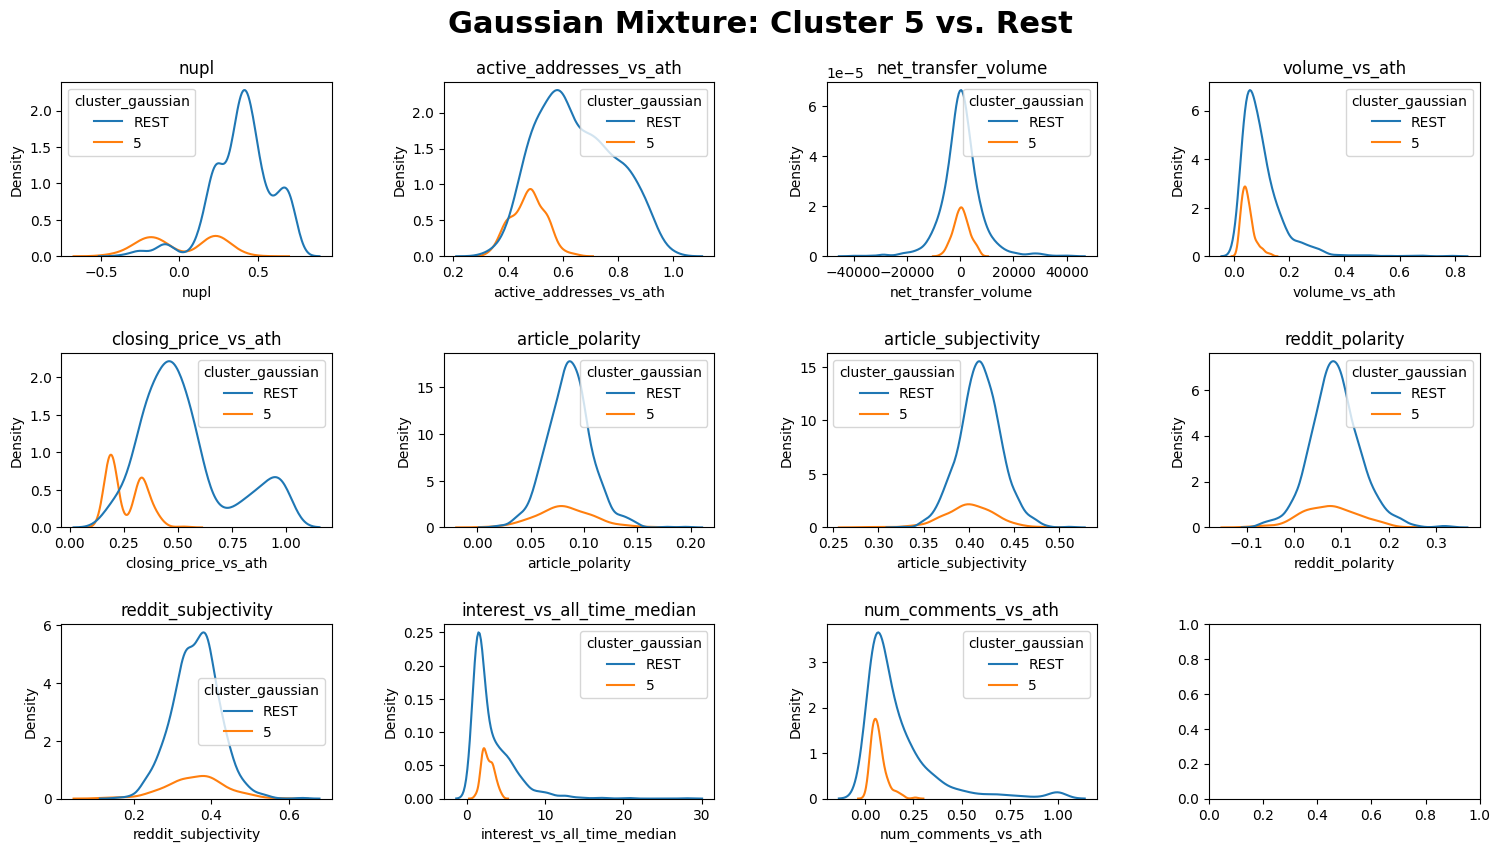

In [99]:
one_vs_rest_kde(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=5, viz_cols=4, title='Gaussian Mixture: Cluster 5 vs. Rest')

In [100]:
one_vs_rest_table(gaussian_6_data.copy(), cluster_col='cluster_gaussian', cluster_val=5).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume                32.536319    -4538.203521    513.227088   
interest_vs_all_time_median        -0.555652       -2.032162      2.687404   
nupl                               -0.388188        0.037963      0.011295   
closing_price_vs_ath               -0.267620       -0.127182      0.262451   
active_addresses_vs_ath            -0.173641       -0.080164      0.472977   
num_comments_vs_ath                -0.101563       -0.148316      0.069270   
volume_vs_ath                      -0.051181       -0.055729      0.049713   
article_subjectivity               -0.011902        0.004861      0.400156   
reddit_polarity                    -0.011711        0.006416      0.076140   
article_polarity                   -0.004499        0.005186      0.081908   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          480.690769  2930.212434  7468.415955   
interest_vs_all_time_median    3.243056     0.728240     2.760402   
nupl                           0.399484     0.228841     0.190879   
closing_price_vs_ath           0.530071     0.081910     0.209092   
active_addresses_vs_ath        0.646618     0.060410     0.140574   
num_comments_vs_ath            0.170832     0.039704     0.188020   
volume_vs_ath                  0.100894     0.023247     0.078976   
article_subjectivity           0.412057     0.028152     0.023291   
reddit_polarity                0.087852     0.058934     0.052518   
article_polarity               0.086407     0.026030     0.020845   

                             Cluster Min  Cluster Max      Rest Min  \
net_transfer_volume         -7110.859612  7368.232907 -39963.566228   
interest_vs_all_time_median     1.052782     4.500000      0.698448   
nupl                           -0.431485     0.454404     -0.371567   
closing_price_vs_ath            0.161985     0.524961      0.172011   
active_addresses_vs_ath         0.335241     0.643663      0.315139   
num_comments_vs_ath             0.005258     0.260038      0.002868   
volume_vs_ath                   0.015860     0.132106      0.012939   
article_subjectivity            0.286019     0.485680      0.326139   
reddit_polarity                -0.090448     0.264403     -0.071107   
article_polarity                0.007928     0.165295      0.017046   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
nupl                             0.748802  
closing_price_vs_ath             1.000000  
active_addresses_vs_ath          1.000000  
num_comments_vs_ath              1.000000  
volume_vs_ath                    0.787208  
article_subjectivity             0.510601  
reddit_polarity                  0.326905  
article_polarity                 0.195214

## One vs. Rest Plots - Hierarchical Agglomerative Clustering - 6 Clusters

In [101]:
# Drop irrelevant columns
hac_6_data = sentiment_cluster_data.drop(columns=['cluster_kmeans_9', 'cluster_hdbscan', 'cluster_dbscan', 'cluster_gaussian', 'cluster_kmeans_6'])

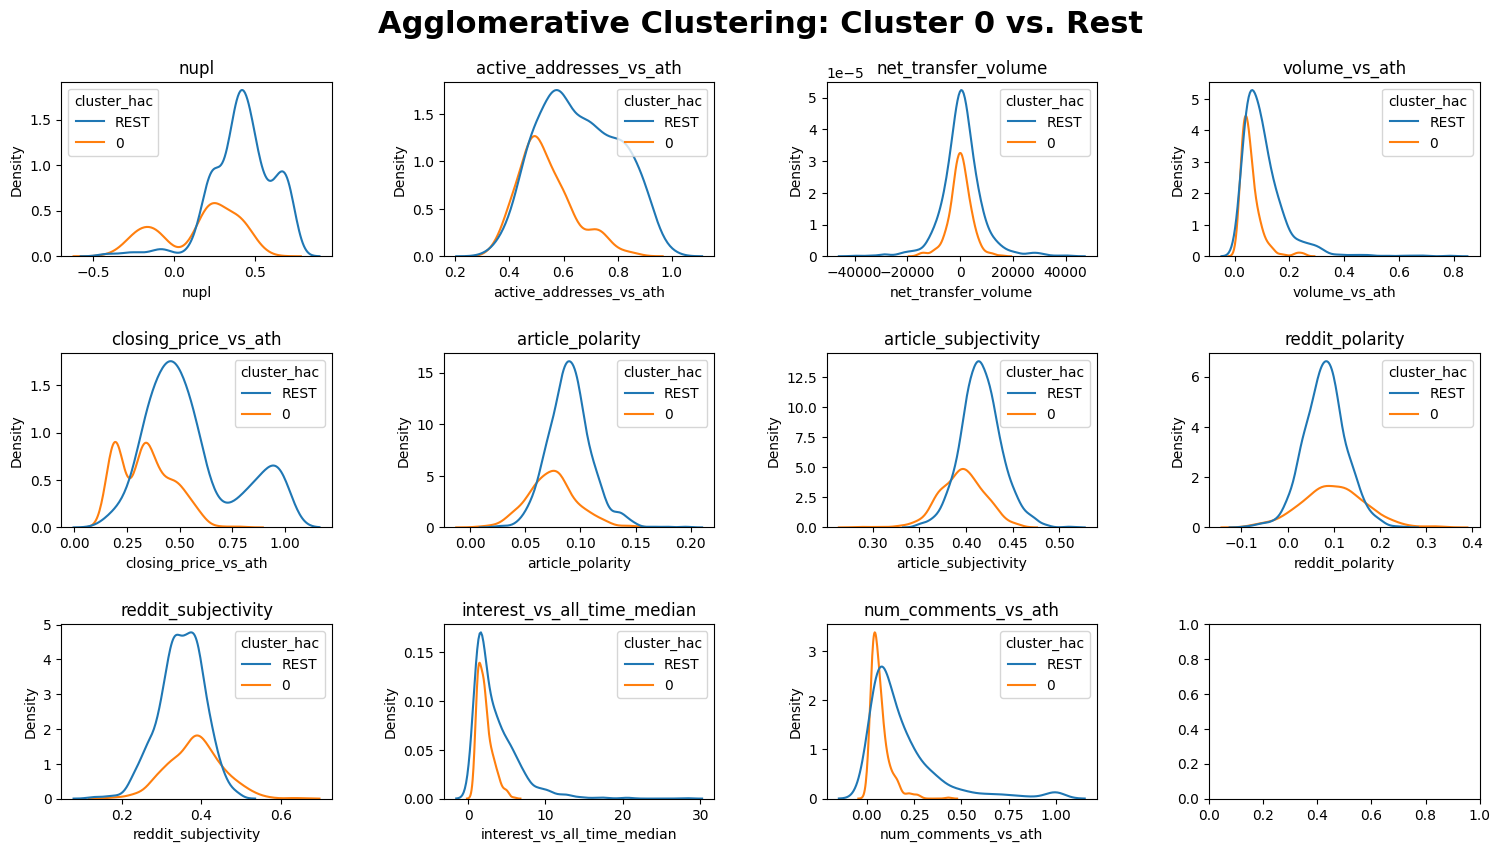

In [102]:
one_vs_rest_kde(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=0, viz_cols=4, title='Agglomerative Clustering: Cluster 0 vs. Rest')

In [103]:
one_vs_rest_table(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=0).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume              -691.336004    -3603.526242     -6.300466   
interest_vs_all_time_median        -1.419788       -1.933479      2.152808   
nupl                               -0.269000        0.048609      0.151961   
closing_price_vs_ath               -0.214924       -0.090240      0.338464   
active_addresses_vs_ath            -0.122446       -0.042738      0.534391   
num_comments_vs_ath                -0.121373       -0.147012      0.069804   
volume_vs_ath                      -0.048924       -0.044084      0.058688   
reddit_subjectivity                 0.034994        0.011205      0.384968   
article_subjectivity               -0.020555        0.002417      0.395715   
reddit_polarity                     0.017789        0.022241      0.098809   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          685.035538  4233.508311  7837.034552   
interest_vs_all_time_median    3.572595     0.959530     2.893009   
nupl                           0.420960     0.239650     0.191041   
closing_price_vs_ath           0.553388     0.125763     0.216004   
active_addresses_vs_ath        0.656837     0.102697     0.145435   
num_comments_vs_ath            0.191177     0.051255     0.198267   
volume_vs_ath                  0.107612     0.038268     0.082352   
reddit_subjectivity            0.349973     0.067675     0.056470   
article_subjectivity           0.416270     0.024258     0.021841   
reddit_polarity                0.081019     0.067899     0.045658   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -15599.786568  15414.516038 -39963.566228   
interest_vs_all_time_median      0.750000      5.877660      0.698448   
nupl                            -0.401820      0.560104     -0.431485   
closing_price_vs_ath             0.162631      0.780776      0.161985   
active_addresses_vs_ath          0.335241      0.871492      0.315139   
num_comments_vs_ath              0.002868      0.430688      0.005258   
volume_vs_ath                    0.012939      0.256356      0.015777   
reddit_subjectivity              0.179722      0.635275      0.122346   
article_subjectivity             0.286019      0.453829      0.349301   
reddit_polarity                 -0.080692      0.326905     -0.090448   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
nupl                             0.748802  
closing_price_vs_ath             1.000000  
active_addresses_vs_ath          1.000000  
num_comments_vs_ath              1.000000  
volume_vs_ath                    0.787208  
reddit_subjectivity              0.492236  
article_subjectivity             0.510601  
reddit_polarity                  0.246956

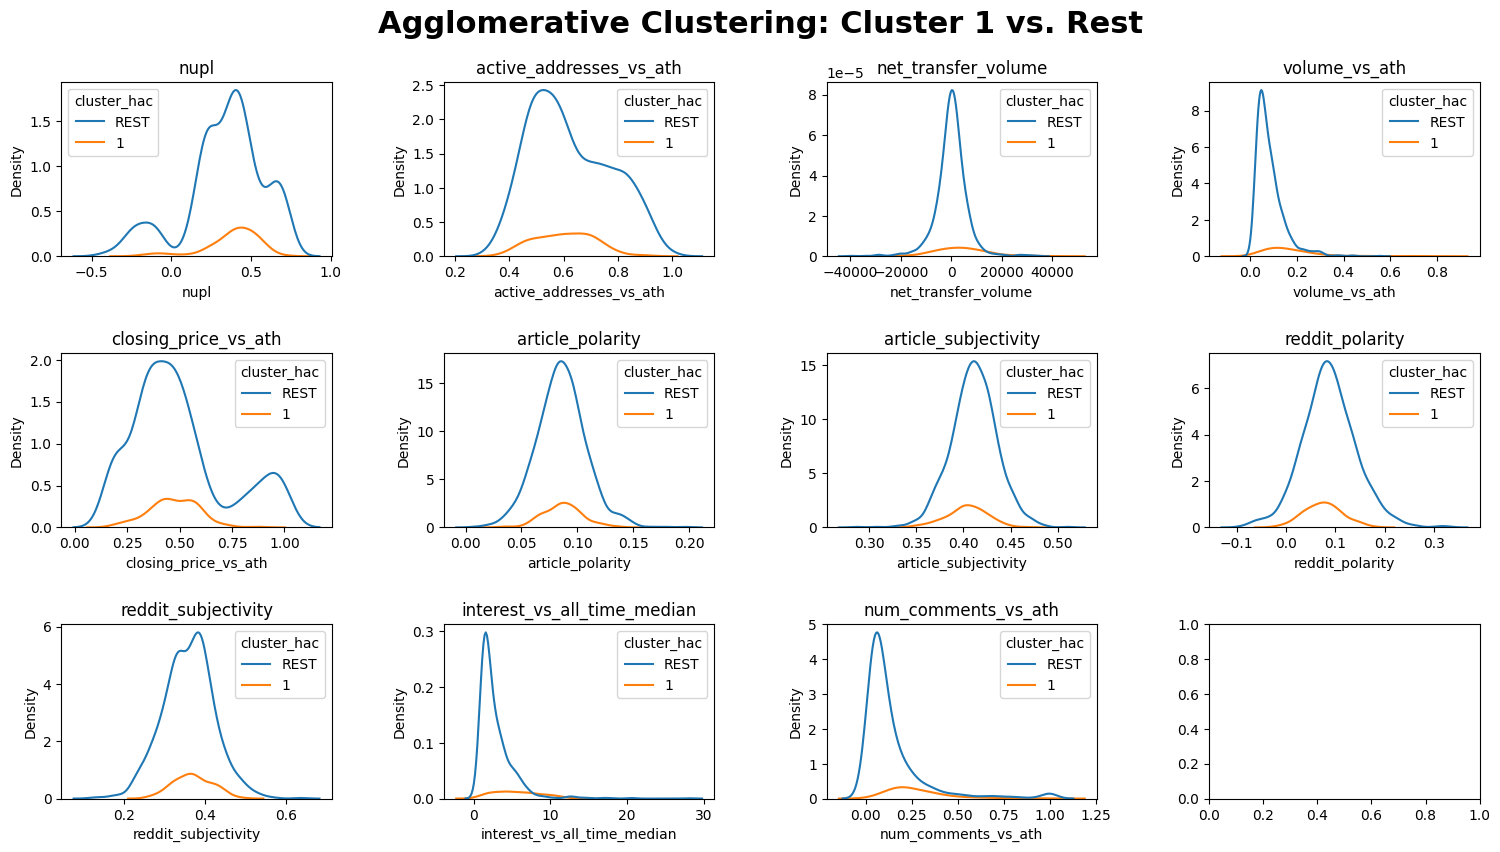

In [104]:
one_vs_rest_kde(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=1, viz_cols=4, title='Agglomerative Clustering: Cluster 1 vs. Rest')

In [105]:
one_vs_rest_table(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=1).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume              4113.157981     4173.090361   4149.496175   
interest_vs_all_time_median         2.753441        0.535305      5.615437   
num_comments_vs_ath                 0.137253       -0.004308      0.278396   
volume_vs_ath                       0.088679        0.067990      0.172481   
nupl                                0.050821       -0.078737      0.388555   
active_addresses_vs_ath            -0.021206       -0.040768      0.602588   
closing_price_vs_ath               -0.020442       -0.109353      0.473115   
reddit_polarity                    -0.012310       -0.016955      0.075190   
reddit_subjectivity                 0.010590       -0.016420      0.369512   
article_subjectivity               -0.007336       -0.003250      0.403800   

                             Rest Mean   Cluster STD     Rest STD  \
net_transfer_volume          36.338194  10475.687840  6302.597479   
interest_vs_all_time_median   2.861996      2.899887     2.364582   
num_comments_vs_ath           0.141143      0.169142     0.173450   
volume_vs_ath                 0.083803      0.127893     0.059903   
nupl                          0.337734      0.167652     0.246389   
active_addresses_vs_ath       0.623794      0.108475     0.149243   
closing_price_vs_ath          0.493557      0.117148     0.226501   
reddit_polarity               0.087500      0.038137     0.055091   
reddit_subjectivity           0.358922      0.047047     0.063467   
article_subjectivity          0.411135      0.021389     0.024639   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -22335.291133  41204.164457 -39963.566228   
interest_vs_all_time_median      0.990000     12.406780      0.698448   
num_comments_vs_ath              0.044455      1.000000      0.002868   
volume_vs_ath                    0.020679      0.787208      0.012939   
nupl                            -0.195322      0.715193     -0.431485   
active_addresses_vs_ath          0.373654      0.897685      0.315139   
closing_price_vs_ath             0.189889      0.871818      0.161985   
reddit_polarity                 -0.020554      0.176500     -0.090448   
reddit_subjectivity              0.262842      0.490897      0.122346   
article_subjectivity             0.349301      0.464619      0.286019   

                                 Rest Max  
net_transfer_volume          34082.052877  
interest_vs_all_time_median     28.000000  
num_comments_vs_ath              1.000000  
volume_vs_ath                    0.555114  
nupl                             0.748802  
active_addresses_vs_ath          1.000000  
closing_price_vs_ath             1.000000  
reddit_polarity                  0.326905  
reddit_subjectivity              0.635275  
article_subjectivity             0.510601

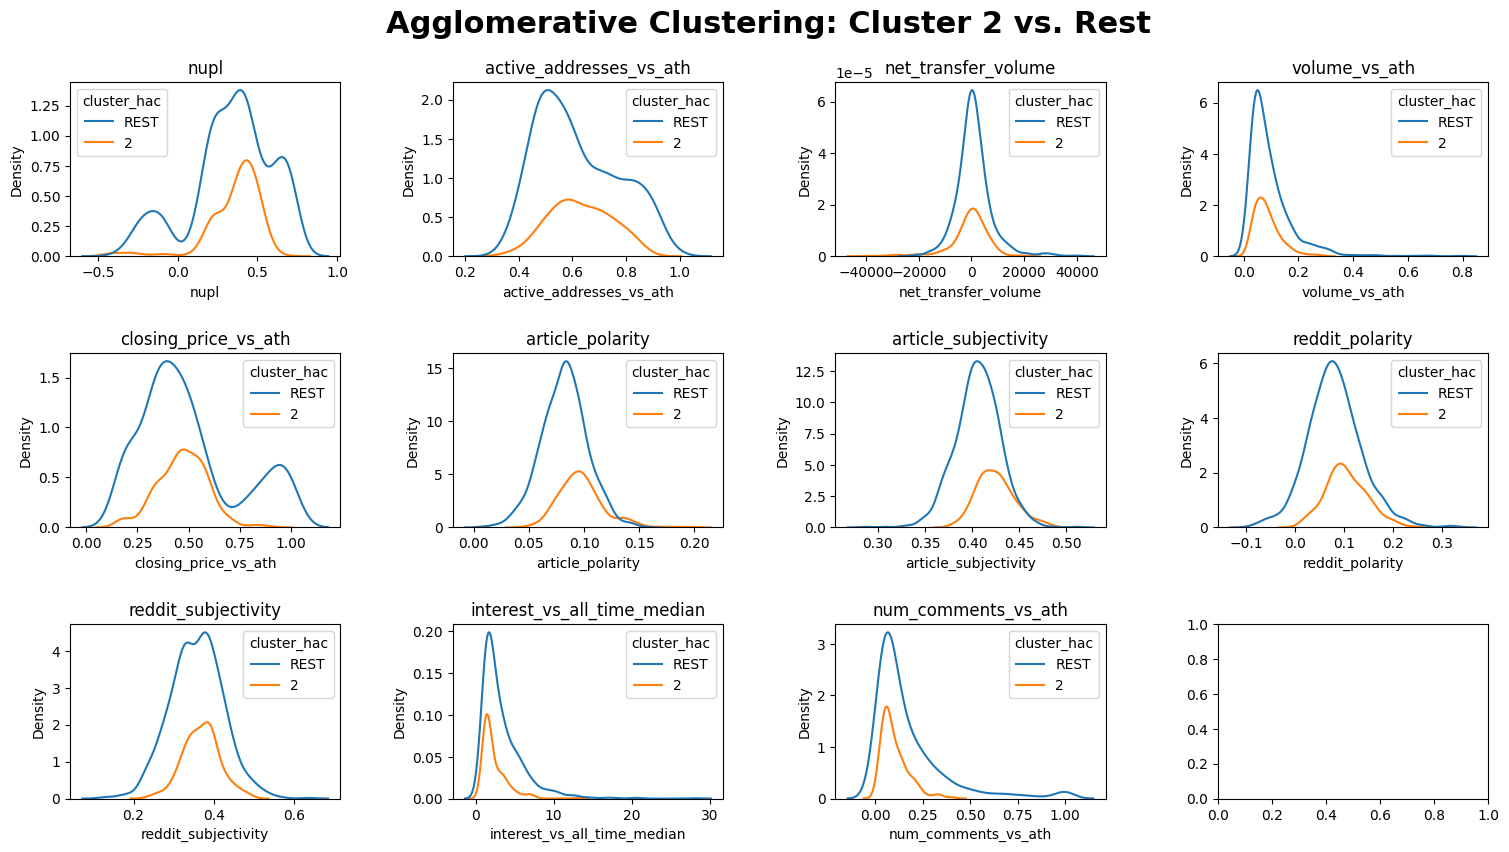

In [106]:
one_vs_rest_kde(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=2, viz_cols=4, title='Agglomerative Clustering: Cluster 2 vs. Rest')

In [107]:
one_vs_rest_table(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=2).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume             -1635.043216      621.170046   -761.577834   
interest_vs_all_time_median        -1.043183       -1.209745      2.367017   
num_comments_vs_ath                -0.071151       -0.125065      0.101865   
closing_price_vs_ath               -0.027482       -0.117386      0.470366   
reddit_polarity                     0.023961       -0.013201      0.104431   
nupl                                0.019292       -0.083534      0.357995   
article_subjectivity                0.019037       -0.003690      0.424853   
article_polarity                    0.015278       -0.000262      0.097408   
reddit_subjectivity                 0.011760       -0.020531      0.369047   
volume_vs_ath                      -0.011305       -0.034714      0.084863   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          873.465382  7432.249236  6811.079190   
interest_vs_all_time_median    3.410200     1.561591     2.771336   
num_comments_vs_ath            0.173015     0.071940     0.197005   
closing_price_vs_ath           0.497848     0.121698     0.239084   
reddit_polarity                0.080469     0.042297     0.055498   
nupl                           0.338704     0.173093     0.256627   
article_subjectivity           0.405816     0.020161     0.023851   
article_polarity               0.082130     0.020531     0.020792   
reddit_subjectivity            0.357287     0.045495     0.066025   
volume_vs_ath                  0.096167     0.047669     0.082383   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -39963.566228  18886.797332 -22335.291133   
interest_vs_all_time_median      0.698448     13.085227      0.750000   
num_comments_vs_ath              0.006692      0.407744      0.002868   
closing_price_vs_ath             0.161985      0.890498      0.162631   
reddit_polarity                  0.007792      0.246956     -0.090448   
nupl                            -0.431485      0.661473     -0.401820   
article_subjectivity             0.378756      0.486127      0.286019   
article_polarity                 0.049243      0.195214      0.007928   
reddit_subjectivity              0.235410      0.492236      0.122346   
volume_vs_ath                    0.015777      0.285351      0.012939   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
num_comments_vs_ath              1.000000  
closing_price_vs_ath             1.000000  
reddit_polarity                  0.326905  
nupl                             0.748802  
article_subjectivity             0.510601  
article_polarity                 0.153029  
reddit_subjectivity              0.635275  
volume_vs_ath                    0.787208

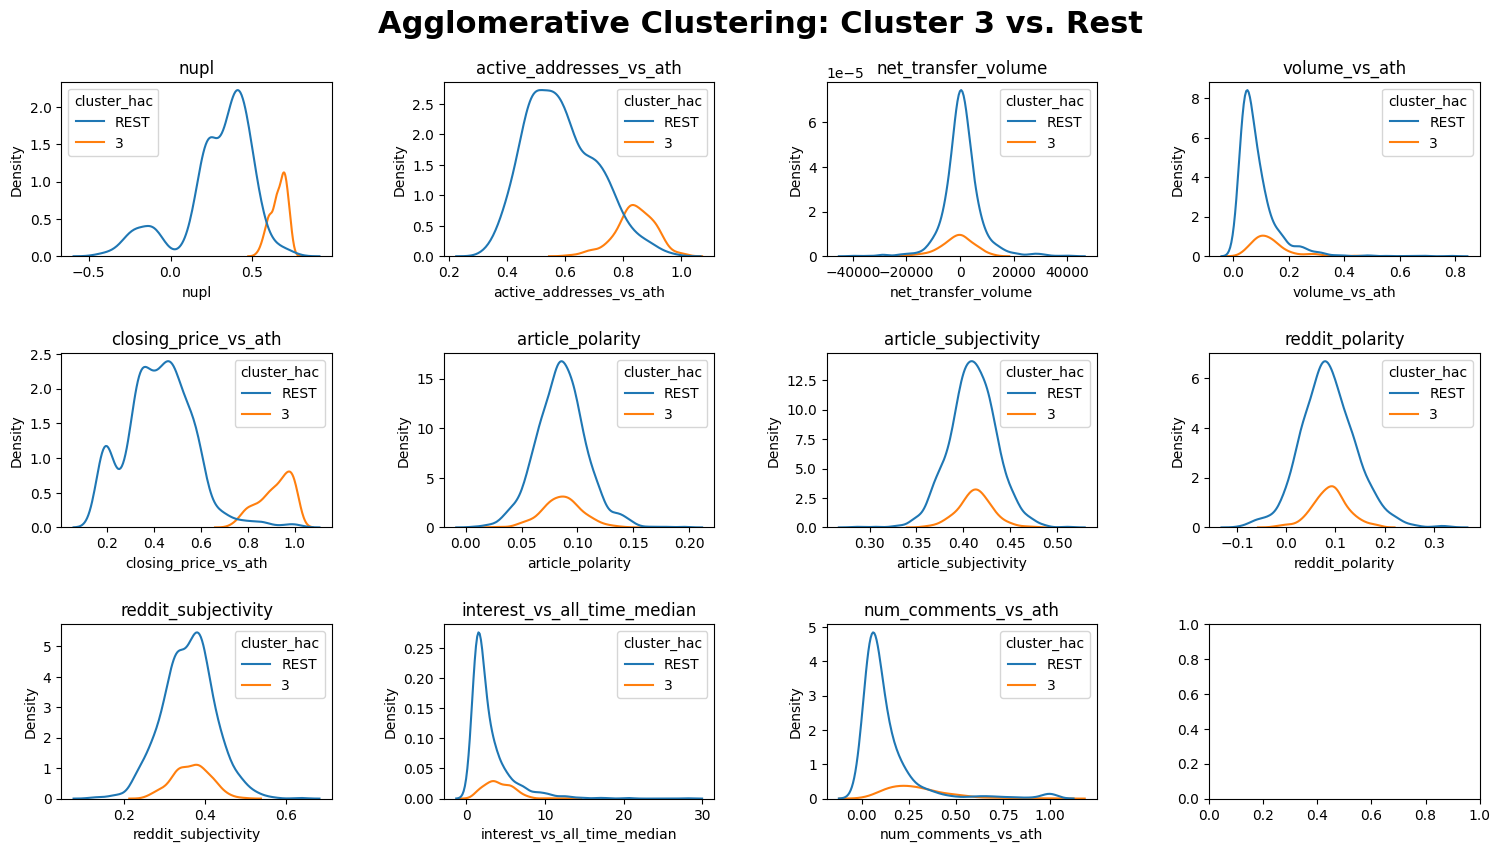

In [108]:
one_vs_rest_kde(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=3, viz_cols=4, title='Agglomerative Clustering: Cluster 3 vs. Rest')

In [109]:
one_vs_rest_table(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=3).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume             -1875.123669     -931.242016  -1130.112656   
interest_vs_all_time_median         1.170037       -0.814946      4.170655   
closing_price_vs_ath                0.493890       -0.071363      0.916836   
nupl                                0.369374       -0.168850      0.661517   
active_addresses_vs_ath             0.254018       -0.054752      0.840328   
num_comments_vs_ath                 0.168514        0.004241      0.301312   
volume_vs_ath                       0.043984       -0.008023      0.131379   
reddit_subjectivity                 0.007308       -0.019906      0.366374   
reddit_polarity                     0.003478       -0.020279      0.089153   
article_subjectivity                0.002741       -0.007046      0.412696   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          745.011013  6157.652068  7088.894085   
interest_vs_all_time_median    3.000618     1.825894     2.640839   
closing_price_vs_ath           0.422946     0.070827     0.142190   
nupl                           0.292143     0.048675     0.217525   
active_addresses_vs_ath        0.586310     0.067303     0.122055   
num_comments_vs_ath            0.132798     0.172075     0.167834   
volume_vs_ath                  0.087395     0.067257     0.075280   
reddit_subjectivity            0.359067     0.044389     0.064295   
reddit_polarity                0.085675     0.035695     0.055974   
article_subjectivity           0.409955     0.018201     0.025247   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -21375.021015  11752.918388 -39963.566228   
interest_vs_all_time_median      1.037037     12.672414      0.698448   
closing_price_vs_ath             0.735600      1.000000      0.161985   
nupl                             0.526589      0.746963     -0.431485   
active_addresses_vs_ath          0.616217      1.000000      0.315139   
num_comments_vs_ath              0.065010      1.000000      0.002868   
volume_vs_ath                    0.038065      0.438805      0.012939   
reddit_subjectivity              0.259857      0.490777      0.122346   
reddit_polarity                 -0.019639      0.182068     -0.090448   
article_subjectivity             0.359115      0.471577      0.286019   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
closing_price_vs_ath             1.000000  
nupl                             0.748802  
active_addresses_vs_ath          0.976224  
num_comments_vs_ath              1.000000  
volume_vs_ath                    0.787208  
reddit_subjectivity              0.635275  
reddit_polarity                  0.326905  
article_subjectivity             0.510601

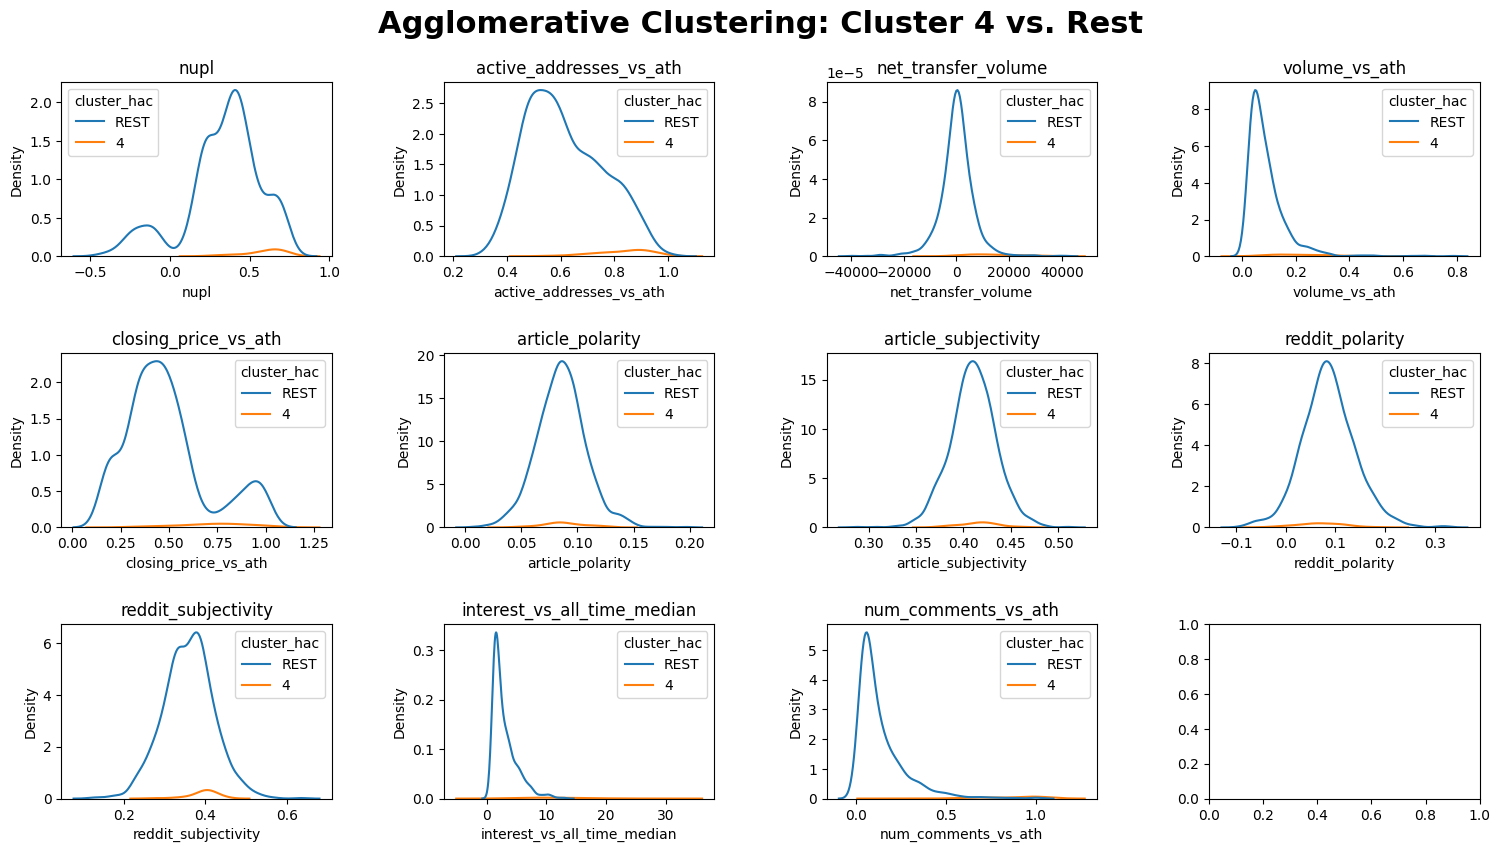

In [110]:
one_vs_rest_kde(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=4, viz_cols=4, title='Agglomerative Clustering: Cluster 4 vs. Rest')

In [111]:
one_vs_rest_table(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=4).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume             14174.682749     3297.403782  14290.017202   
interest_vs_all_time_median         8.502004        3.415230     11.442647   
num_comments_vs_ath                 0.715512        0.046656      0.852960   
nupl                                0.257645       -0.110910      0.594200   
closing_price_vs_ath                0.245070       -0.027801      0.729997   
active_addresses_vs_ath             0.214884       -0.041762      0.830753   
volume_vs_ath                       0.129826        0.036234      0.219921   
reddit_subjectivity                 0.036030       -0.025389      0.395168   
reddit_polarity                    -0.017295       -0.007467      0.069313   
article_subjectivity                0.006348       -0.004371      0.416516   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          115.334452  9815.780837  6518.377055   
interest_vs_all_time_median    2.940642     5.451514     2.036285   
num_comments_vs_ath            0.137448     0.182105     0.135449   
nupl                           0.336556     0.127329     0.238239   
closing_price_vs_ath           0.484927     0.186716     0.214517   
active_addresses_vs_ath        0.615869     0.100569     0.142331   
volume_vs_ath                  0.090095     0.107970     0.071737   
reddit_subjectivity            0.359138     0.036842     0.062231   
reddit_polarity                0.086608     0.046288     0.053755   
article_subjectivity           0.410169     0.020124     0.024495   

                             Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -1761.221062  34082.052877 -39963.566228   
interest_vs_all_time_median     2.970000     28.000000      0.698448   
num_comments_vs_ath             0.278966      1.000000      0.002868   
nupl                            0.252271      0.748802     -0.431485   
closing_price_vs_ath            0.351409      1.000000      0.161985   
active_addresses_vs_ath         0.561488      0.976224      0.315139   
volume_vs_ath                   0.085200      0.555114      0.012939   
reddit_subjectivity             0.271461      0.453645      0.122346   
reddit_polarity                -0.032770      0.177257     -0.090448   
article_subjectivity            0.376603      0.461164      0.286019   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     13.085227  
num_comments_vs_ath              1.000000  
nupl                             0.746963  
closing_price_vs_ath             1.000000  
active_addresses_vs_ath          1.000000  
volume_vs_ath                    0.787208  
reddit_subjectivity              0.635275  
reddit_polarity                  0.326905  
article_subjectivity             0.510601

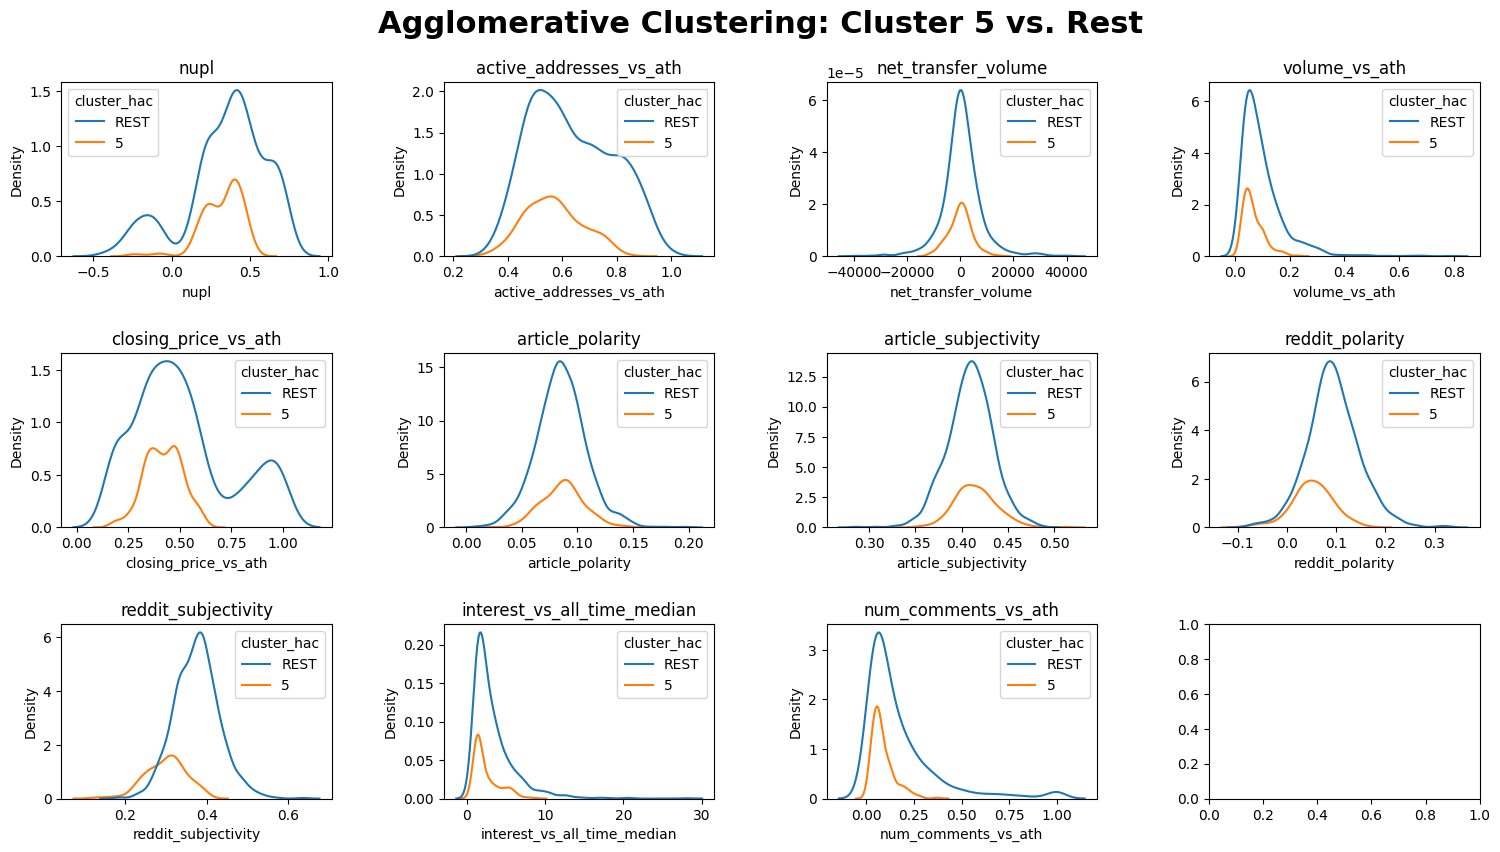

In [112]:
one_vs_rest_kde(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=5, viz_cols=4, title='Agglomerative Clustering: Cluster 5 vs. Rest')

In [113]:
one_vs_rest_table(hac_6_data.copy(), cluster_col='cluster_hac', cluster_val=5).head(10)

Mean Difference  STD Difference  Cluster Mean  \
net_transfer_volume              -617.303725    -3126.177298     -8.343978   
interest_vs_all_time_median        -0.893874       -1.109381      2.447651   
closing_price_vs_ath               -0.087693       -0.144716      0.421184   
num_comments_vs_ath                -0.086420       -0.134933      0.087006   
reddit_subjectivity                -0.075790       -0.004848      0.299458   
active_addresses_vs_ath            -0.065838       -0.046520      0.568819   
reddit_polarity                    -0.042279       -0.010348      0.052340   
volume_vs_ath                      -0.031718       -0.043305      0.068115   
nupl                               -0.023722       -0.130334      0.324308   
article_subjectivity                0.006252       -0.002214      0.415335   

                              Rest Mean  Cluster STD     Rest STD  \
net_transfer_volume          608.959748  4379.110731  7505.288029   
interest_vs_all_time_median    3.341526     1.624292     2.733673   
closing_price_vs_ath           0.508878     0.090783     0.235499   
num_comments_vs_ath            0.173426     0.058301     0.193234   
reddit_subjectivity            0.375248     0.050130     0.054979   
active_addresses_vs_ath        0.634657     0.104670     0.151190   
reddit_polarity                0.094619     0.042458     0.052806   
volume_vs_ath                  0.099833     0.038002     0.081307   
nupl                           0.348031     0.129391     0.259725   
article_subjectivity           0.409083     0.022498     0.024712   

                              Cluster Min   Cluster Max      Rest Min  \
net_transfer_volume         -11458.345131  14515.779716 -39963.566228   
interest_vs_all_time_median      0.840000      8.550000      0.698448   
closing_price_vs_ath             0.173780      0.626171      0.161985   
num_comments_vs_ath              0.005258      0.373805      0.002868   
reddit_subjectivity              0.122346      0.401383      0.179722   
active_addresses_vs_ath          0.315139      0.842417      0.329675   
reddit_polarity                 -0.090448      0.169392     -0.080692   
volume_vs_ath                    0.016463      0.232006      0.012939   
nupl                            -0.258637      0.537859     -0.431485   
article_subjectivity             0.352594      0.510601      0.286019   

                                 Rest Max  
net_transfer_volume          41204.164457  
interest_vs_all_time_median     28.000000  
closing_price_vs_ath             1.000000  
num_comments_vs_ath              1.000000  
reddit_subjectivity              0.635275  
active_addresses_vs_ath          1.000000  
reddit_polarity                  0.326905  
volume_vs_ath                    0.787208  
nupl                             0.748802  
article_subjectivity             0.486127

## Tableau Data Preparation

In [114]:
# Grab presentation columns from the model_data
tableau_cols = ['date', 'nupl', 'active_addresses', 'active_addresses_vs_ath',
                'net_transfer_volume', 'volume', 'volume_vs_ath', 'closing_price',
                'closing_price_vs_ath', 'article_polarity', 'article_subjectivity',
                'reddit_polarity', 'reddit_polarity_scaled', 'reddit_subjectivity',
                'reddit_polarity_std', 'reddit_polarity_scaled_std',
                'reddit_subjectivity_std', 'subjectivity_scaled', 'num_comments',
                'google_activity', 'num_comments_vs_ath']

tableau_data = model_data[tableau_cols]

In [116]:
# Merge in the cluster labels
tableau_data = tableau_data.merge(sentiment_cluster_data.reset_index()[['date', 'cluster_kmeans_6', 'cluster_kmeans_9', 'cluster_gaussian', 'cluster_hac']], how='left', on='date')

In [117]:
tableau_data.to_excel('bitcoin_sentiment.xlsx')